<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs" data-toc-modified-id="Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs-1">Analysis of full-length PacBio sequencing of influenza mRNAs</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span><ul class="toc-item"><li><span><a href="#Import-Python-modules" data-toc-modified-id="Import-Python-modules-1.1.1">Import Python modules</a></span></li><li><span><a href="#Define-/-create-directories" data-toc-modified-id="Define-/-create-directories-1.1.2">Define / create directories</a></span></li><li><span><a href="#How-many-CPUs-to-use" data-toc-modified-id="How-many-CPUs-to-use-1.1.3">How many CPUs to use</a></span></li></ul></li><li><span><a href="#Build-CCSs" data-toc-modified-id="Build-CCSs-1.2">Build CCSs</a></span><ul class="toc-item"><li><span><a href="#Get-subreads-files" data-toc-modified-id="Get-subreads-files-1.2.1">Get subreads files</a></span></li><li><span><a href="#Run-ccs" data-toc-modified-id="Run-ccs-1.2.2">Run <code>ccs</code></a></span></li><li><span><a href="#Number-of-CCSs" data-toc-modified-id="Number-of-CCSs-1.2.3">Number of CCSs</a></span></li><li><span><a href="#CCS-accuracy-/-length" data-toc-modified-id="CCS-accuracy-/-length-1.2.4">CCS accuracy / length</a></span></li></ul></li><li><span><a href="#Align-CCSs-to-flu-genes" data-toc-modified-id="Align-CCSs-to-flu-genes-1.3">Align CCSs to flu genes</a></span><ul class="toc-item"><li><span><a href="#Barcoded-CCS-features" data-toc-modified-id="Barcoded-CCS-features-1.3.1">Barcoded CCS features</a></span></li><li><span><a href="#Flu-alignment-targets" data-toc-modified-id="Flu-alignment-targets-1.3.2">Flu alignment targets</a></span></li><li><span><a href="#Match-and-align-CCSs" data-toc-modified-id="Match-and-align-CCSs-1.3.3">Match and align CCSs</a></span></li><li><span><a href="#Stats-on-matching-/-alignment" data-toc-modified-id="Stats-on-matching-/-alignment-1.3.4">Stats on matching / alignment</a></span></li><li><span><a href="#Get-CCSs-with-gene-aligned" data-toc-modified-id="Get-CCSs-with-gene-aligned-1.3.5">Get CCSs with gene aligned</a></span></li></ul></li><li><span><a href="#Quality-control-alignments" data-toc-modified-id="Quality-control-alignments-1.4">Quality-control alignments</a></span><ul class="toc-item"><li><span><a href="#Barcode-accuracy" data-toc-modified-id="Barcode-accuracy-1.4.1">Barcode accuracy</a></span></li><li><span><a href="#Additional-alignments" data-toc-modified-id="Additional-alignments-1.4.2">Additional alignments</a></span></li><li><span><a href="#Excessive-alignment-trimming" data-toc-modified-id="Excessive-alignment-trimming-1.4.3">Excessive alignment trimming</a></span><ul class="toc-item"><li><span><a href="#Trimming-of-query-start" data-toc-modified-id="Trimming-of-query-start-1.4.3.1">Trimming of query start</a></span></li><li><span><a href="#Trimming-of-target-start" data-toc-modified-id="Trimming-of-target-start-1.4.3.2">Trimming of target start</a></span></li><li><span><a href="#Trimming-query-ends" data-toc-modified-id="Trimming-query-ends-1.4.3.3">Trimming query ends</a></span></li><li><span><a href="#Trimming-target-ends" data-toc-modified-id="Trimming-target-ends-1.4.3.4">Trimming target ends</a></span></li></ul></li><li><span><a href="#Get-QC-ed-alignments" data-toc-modified-id="Get-QC-ed-alignments-1.4.4">Get QC-ed alignments</a></span></li></ul></li><li><span><a href="#Summary-of-QC-ed-alignments" data-toc-modified-id="Summary-of-QC-ed-alignments-1.5">Summary of QC-ed alignments</a></span><ul class="toc-item"><li><span><a href="#Number-of-alignments-per-gene" data-toc-modified-id="Number-of-alignments-per-gene-1.5.1">Number of alignments per gene</a></span></li><li><span><a href="#Distribution-of-alignment-lengths" data-toc-modified-id="Distribution-of-alignment-lengths-1.5.2">Distribution of alignment lengths</a></span></li><li><span><a href="#Near-full-length-alignments" data-toc-modified-id="Near-full-length-alignments-1.5.3">Near full-length alignments</a></span></li><li><span><a href="#Passes/accuracy-for-alignments" data-toc-modified-id="Passes/accuracy-for-alignments-1.5.4">Passes/accuracy for alignments</a></span></li></ul></li><li><span><a href="#Analyze-viral-barcodes" data-toc-modified-id="Analyze-viral-barcodes-1.6">Analyze viral barcodes</a></span><ul class="toc-item"><li><span><a href="#Inspect-viral-barcodes-by-gene" data-toc-modified-id="Inspect-viral-barcodes-by-gene-1.6.1">Inspect viral barcodes by gene</a></span></li><li><span><a href="#Estimate-rate-of-PCR-strand-exchange" data-toc-modified-id="Estimate-rate-of-PCR-strand-exchange-1.6.2">Estimate rate of PCR strand exchange</a></span></li><li><span><a href="#Filter-chimeras,-assign-viral-barcodes" data-toc-modified-id="Filter-chimeras,-assign-viral-barcodes-1.6.3">Filter chimeras, assign viral barcodes</a></span></li></ul></li><li><span><a href="#Examine-10X-cell-barcodes-/-UMIs" data-toc-modified-id="Examine-10X-cell-barcodes-/-UMIs-1.7">Examine 10X cell barcodes / UMIs</a></span><ul class="toc-item"><li><span><a href="#Get-valid-cell-barcodes" data-toc-modified-id="Get-valid-cell-barcodes-1.7.1">Get valid cell barcodes</a></span></li><li><span><a href="#Filter-alignments-from-valid-cells" data-toc-modified-id="Filter-alignments-from-valid-cells-1.7.2">Filter alignments from valid cells</a></span></li><li><span><a href="#Per-gene-barcodes-/-UMI-sampling" data-toc-modified-id="Per-gene-barcodes-/-UMI-sampling-1.7.3">Per-gene barcodes / UMI sampling</a></span></li><li><span><a href="#Genes-sequenced-per-cell" data-toc-modified-id="Genes-sequenced-per-cell-1.7.4">Genes sequenced per cell</a></span></li></ul></li><li><span><a href="#Call-mutations" data-toc-modified-id="Call-mutations-1.8">Call mutations</a></span><ul class="toc-item"><li><span><a href="#Number-of-mutations-per-gene" data-toc-modified-id="Number-of-mutations-per-gene-1.8.1">Number of mutations per gene</a></span></li><li><span><a href="#Lengths-of-indels" data-toc-modified-id="Lengths-of-indels-1.8.2">Lengths of indels</a></span></li><li><span><a href="#Accuracy-of-mutations" data-toc-modified-id="Accuracy-of-mutations-1.8.3">Accuracy of mutations</a></span></li></ul></li><li><span><a href="#Analyze-flu-sequences-at-cell-level" data-toc-modified-id="Analyze-flu-sequences-at-cell-level-1.9">Analyze flu sequences at cell level</a></span><ul class="toc-item"><li><span><a href="#Aggregate-data-at-the-cell-level" data-toc-modified-id="Aggregate-data-at-the-cell-level-1.9.1">Aggregate data at the cell level</a></span></li><li><span><a href="#Genes-sequenced-per-cell" data-toc-modified-id="Genes-sequenced-per-cell-1.9.2">Genes sequenced per cell</a></span></li></ul></li><li><span><a href="#Call-mutations-for-viruses-in-cells" data-toc-modified-id="Call-mutations-for-viruses-in-cells-1.10">Call mutations for viruses in cells</a></span></li></ul></li></ul></div>

# Analysis of full-length PacBio sequencing of influenza mRNAs
The material from the 10X libraries for the *IFN_enriched* sample was enriched for viral mRNAs by semi-specific PCR, and then sequenced by PacBio.
Here we analyze those data.

## Set up for analysis
First, we do some things to set up this Jupyter notebook.

### Import Python modules
We import the Python modules used.

We make extensive use of [dms_tools2](https://jbloomlab.github.io/dms_tools2/) to handle the PacBio data.

We import [plotnine](https://plotnine.readthedocs.io/en/latest/) for plotting using a ggplot2-like syntax.

In [1]:
import os
import re
import glob
import subprocess
import shutil
import multiprocessing
import warnings
import collections
warnings.simplefilter('ignore')

import numpy
import pandas
from IPython.display import display, HTML, Image
import Bio.SeqIO

# import plotnine for ggplot2 style plotting
from plotnine import *
_ = theme_set(theme_bw(base_size=12))

import dms_tools2
print("Using dms_tools2 version {0}".format(dms_tools2.__version__))
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY

Using dms_tools2 version 2.3.dev0


### Define / create directories
We define the names of key directories for input and output, and create these directories if needed:

In [2]:
# top results directory
resultsdir = './results/'

# directory for PacBio results
pacbioresultsdir = os.path.join(resultsdir, 'pacbio')
os.makedirs(pacbioresultsdir, exist_ok=True)

### How many CPUs to use
Specify max number to use:

In [3]:
max_cpus = 16 # max number of CPUs to use
ncpus = max(multiprocessing.cpu_count(), max_cpus)

## Build CCSs 
We build the circular consensus sequences (CCSs) using the PacBio software.

### Get subreads files 
We have multiple sequencing runs:
  - A run from June-8-2017 done at the UW PacBio core. This run used a PacBio RSII machine.
  - A run from December-7-2017 done at the Fred Hutch Genomics core. This run used a PacBio Sequel machine.
  - A series of runs done on June-22-2018 at the Fred Hutch Genomics Core using a PacBio Sequel machine. These runs were:
      - One that was run on a mix of all non-polymerase genes
      - Two that were run on a mix of just the polymerase genes
      - One that was run on a mix of just the polymerase genes that were amplified using an open PCR rather than an emulsion PCR, and for which a size-selection was performed to attempt to obtain more full-length genes.
  
Note that the material sequenced for these various runs was **not** identical. 
The balance of genes that were mixed differed, as well as the size selection and the way that the libraries were loaded.
Therefore, we do not expect the same balance of different reads in the two runs.

In addition, the data were processed differently.
For the Hutch Genomics Core runs, the data are already processed into a `*.subreads.bam` file, while for UW PacBio core runs it is still in the `*.bas.h5` file.

In [4]:
seqruns = ['2017-06-08', '2017-12-07', '2018-06-22_nonPol', '2018-06-22_Pol-1',
           '2018-06-22_Pol-2', '2018-06-22_Pol_open']

baseseqdir = '/fh/fast/bloom_j/SR/ngs/' # all sequencing data here
seqdirs = {
        '2017-06-08':os.path.join(baseseqdir, 
            'pacbio_UW/170608 Pacbio single cell/Emulsion Reaction/ABR_C_MACS.AR_0kb'),
        '2017-12-07':os.path.join(baseseqdir,
            'pacbio/171207_bloom_j/r54228_20171201_171054/1_A01'),
        '2018-06-22_nonPol':os.path.join(baseseqdir,
            'pacbio/180622_bloom_j/r54228_20180622_194519/1_A01'),
        '2018-06-22_Pol-1':os.path.join(baseseqdir,
            'pacbio/180622_bloom_j/r54228_20180622_194519/2_B01'),
        '2018-06-22_Pol-2':os.path.join(baseseqdir,
            'pacbio/180622_bloom_j/r54228_20180622_194519/3_C01'),
        '2018-06-22_Pol_open':os.path.join(baseseqdir,
            'pacbio/180622_bloom_j/r54228_20180622_194519/4_D01'),
        }
assert set(seqruns) <= set(seqdirs.keys())

bam_already = collections.defaultdict(lambda: True)
bam_already['2017-06-08'] = False

Now we get the `*.subreads.bam` file for each run.
If they already exist (e.g., if data were returned by the Fred Hutch Genomics Core), we just need to get the name of the file.
But if they don't exist (e.g., if data were returned from UW PacBio Core), we need to run the PacBio [bax2bam](https://github.com/PacificBiosciences/bax2bam) software to create the `*subreads.bam` files from the `*.bas.h5` files.

In [5]:
# put or copy subreads into this directory
subreadsdir = os.path.join(pacbioresultsdir, 'subreads')
os.makedirs(subreadsdir, exist_ok=True)

# store name of subreads files for each sequencing run
subreads = collections.OrderedDict([(seqrun, 
        os.path.join(subreadsdir, seqrun + '.subreads.bam')) for seqrun in seqruns])

# get subreads files
for (seqrun, subreadsfile) in subreads.items():
    print("\nGetting subreads for {0} sequencing run".format(seqrun))
    
    if os.path.isfile(subreadsfile):
        print("Subreads file already exists: {0}".format(subreadsfile))
    
    elif bam_already[seqrun]:
        print("Looking for existing subreads file...")
        filepattern = os.path.join(seqdirs[seqrun], '*.subreads.bam')
        existingfiles = glob.glob(filepattern)
        assert existingfiles, "No file matching expected pattern of {0}".format(filepattern)
        assert len(existingfiles) == 1, "Expected one file, but found multiple:\n{0}".format(
                '\n'.join(existingfiles))
        print("Copying subreads file {0} to {1}...".format(existingfiles[0], subreadsfile))
        shutil.copy(existingfiles[0], subreadsfile)
        shutil.copy(existingfiles[0] + '.pbi', subreadsfile + '.pbi')
        print("Completed copying file.")
    
    else:
        print("Building subreads using `bax2bam` version {0}".format(
                subprocess.check_output(['bax2bam', '--version']).decode('utf-8').strip()))
        baxfiles = []
        for (dpath, dirnames, fnames) in os.walk(seqdirs[seqrun]):
            baxfiles += [os.path.join(dpath, fname) for fname in fnames if fname.endswith('.bax.h5')] 
        assert len(baxfiles) > 0, "found no `*.bax.h5` files"
        print("Will build subreads from the following `*.bax.h5` files:\n\t{0}".format(
                '\n\t'.join(baxfiles)))
        print("Now running `bax2bam`...")
        ! bax2bam \
                {' '.join(['"' + x + '"' for x in baxfiles])} \
                -o {subreadsfile.replace('.subreads.bam', '')} \
                --subread
        print("Completed running `bax2bam` to create {0}".format(subreadsfile))
        assert os.path.isfile(subreadsfile)


Getting subreads for 2017-06-08 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-06-08.subreads.bam

Getting subreads for 2017-12-07 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-12-07.subreads.bam

Getting subreads for 2018-06-22_nonPol sequencing run
Subreads file already exists: ./results/pacbio/subreads/2018-06-22_nonPol.subreads.bam

Getting subreads for 2018-06-22_Pol-1 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2018-06-22_Pol-1.subreads.bam

Getting subreads for 2018-06-22_Pol-2 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2018-06-22_Pol-2.subreads.bam

Getting subreads for 2018-06-22_Pol_open_sizesel sequencing run
Subreads file already exists: ./results/pacbio/subreads/2018-06-22_Pol_open_sizesel.subreads.bam


### Run `ccs`
We build CCS's using PacBio's algorithm as implemented in the [ccs program](https://github.com/PacificBiosciences/unanimity/blob/develop/doc/PBCCS.md).

We only want reasonably high-quality CCSs.
The [ccs program](https://github.com/PacificBiosciences/unanimity/blob/master/doc/PBCCS.md) provides two ways to control the "accuracy" of reads.
The first is the `--minPasses` option, which corresponds to how many subreads we require to call a circular consensus sequence.
The second is the `--minPredictedAccuracy` option, which provides an explicit estimate of the accuracy.
We will further post-process the CCSs, so we set reasonably high but not extremely stringent values: 3 passes, and at least 99.9% accuracy.

We read each set of results into ` dms_tools2.pacbio.CCS` object:

In [6]:
ccsdir = os.path.join(pacbioresultsdir, 'ccs')
os.makedirs(ccsdir, exist_ok=True)

minpasses = 3 # require at least this many passes
minaccuracy = 0.999 # require at least this accuracy

ccslist = []
for (seqrun, subreadsfile) in subreads.items():
    print("\nRunning `ccs` for sequencing run {0}".format(seqrun))
        
    reportfile = os.path.join(ccsdir, seqrun + '_report.csv')
    bamfile = os.path.join(ccsdir, seqrun + '_ccs.bam')
    logfile = os.path.join(ccsdir, seqrun + '_log.txt')
        
    if all(map(os.path.isfile, [reportfile, bamfile])):
        print("The `ccs` output already exists, so using that existing output.")
    else:  
        print("Running {0}...".format(
                subprocess.check_output(['ccs', '--version']).decode(
                'utf-8').strip()))
        ! ccs \
            --minLength 100 \
            --maxLength 5000 \
            --minPasses {minpasses} \
            --minPredictedAccuracy {minaccuracy} \
            --logFile {logfile} \
            --reportFile {reportfile} \
            --polish \
            --numThreads {ncpus} \
            {subreadsfile} \
            {bamfile}
        print("Completed `ccs` run.")
        
    ccslist.append(dms_tools2.pacbio.CCS(seqrun, bamfile, reportfile))


Running `ccs` for sequencing run 2017-06-08
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2017-12-07
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2018-06-22_nonPol
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2018-06-22_Pol-1
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2018-06-22_Pol-2
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2018-06-22_Pol_open_sizesel
The `ccs` output already exists, so using that existing output.


### Number of CCSs
Now we summarize the results on the number of CCSs successfully created:

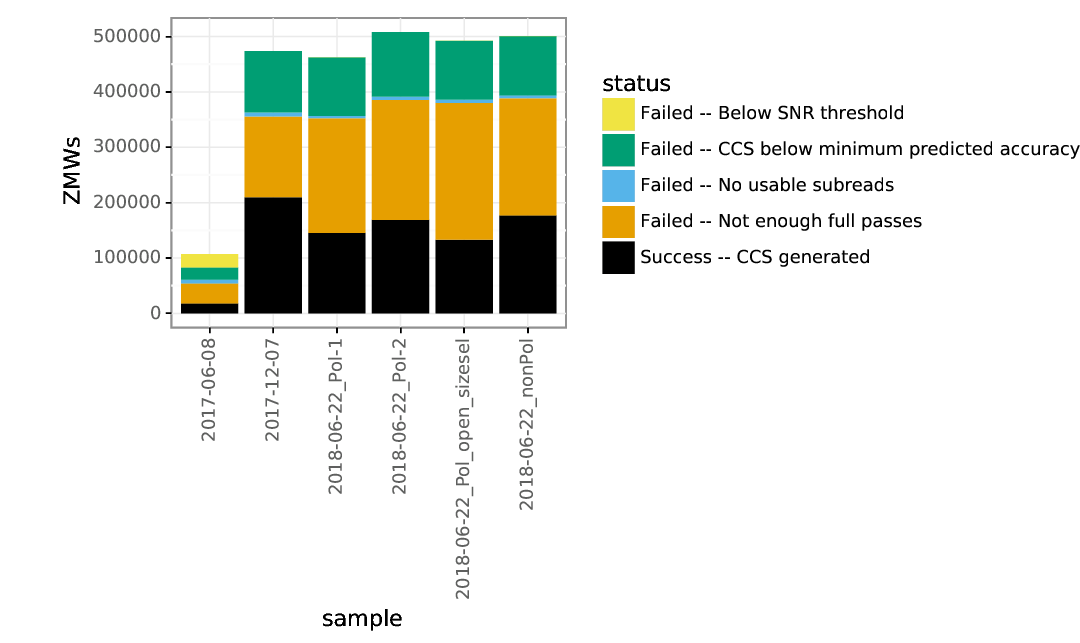

In [7]:
zmw_plot = os.path.join(ccsdir, 'ZMW_plot.pdf')

ccs_report = dms_tools2.pacbio.summarizeCCSreports(
                ccslist, 'zmw', zmw_plot)
showPDF(zmw_plot)

### CCS accuracy / length
Now we plot the distributions of lengths, accuracies, and number of passes for the CCSs:

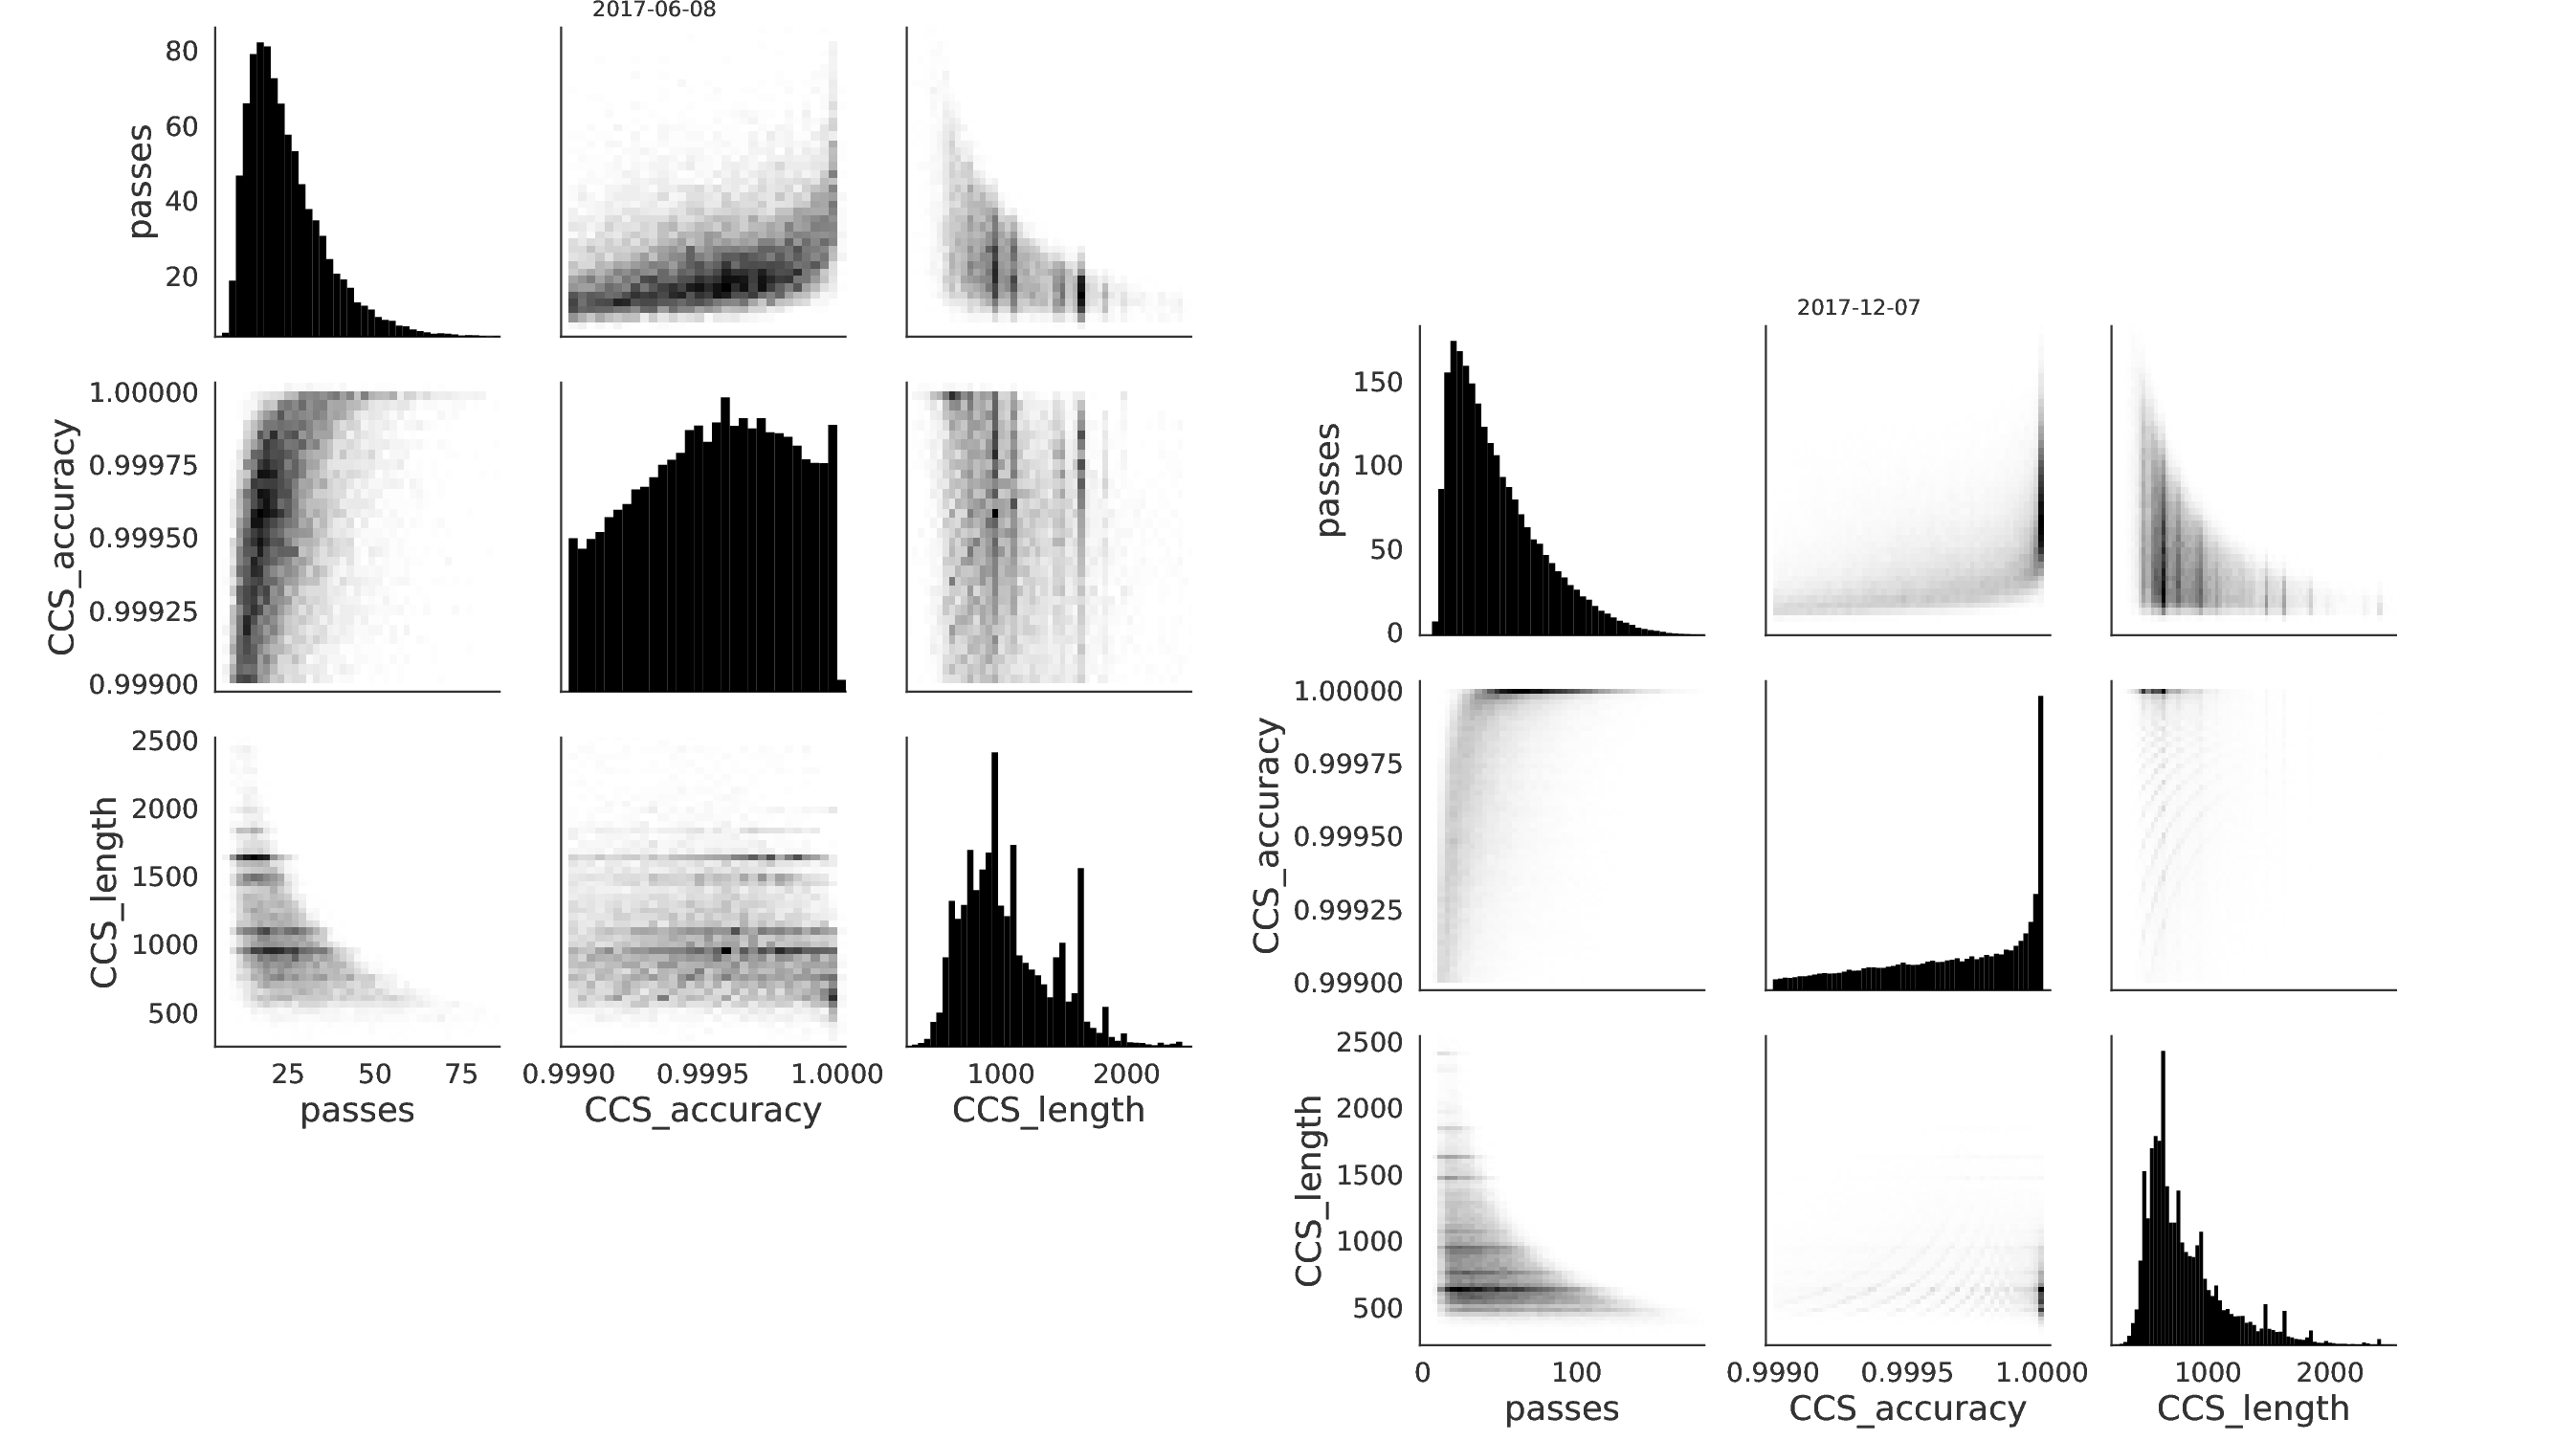

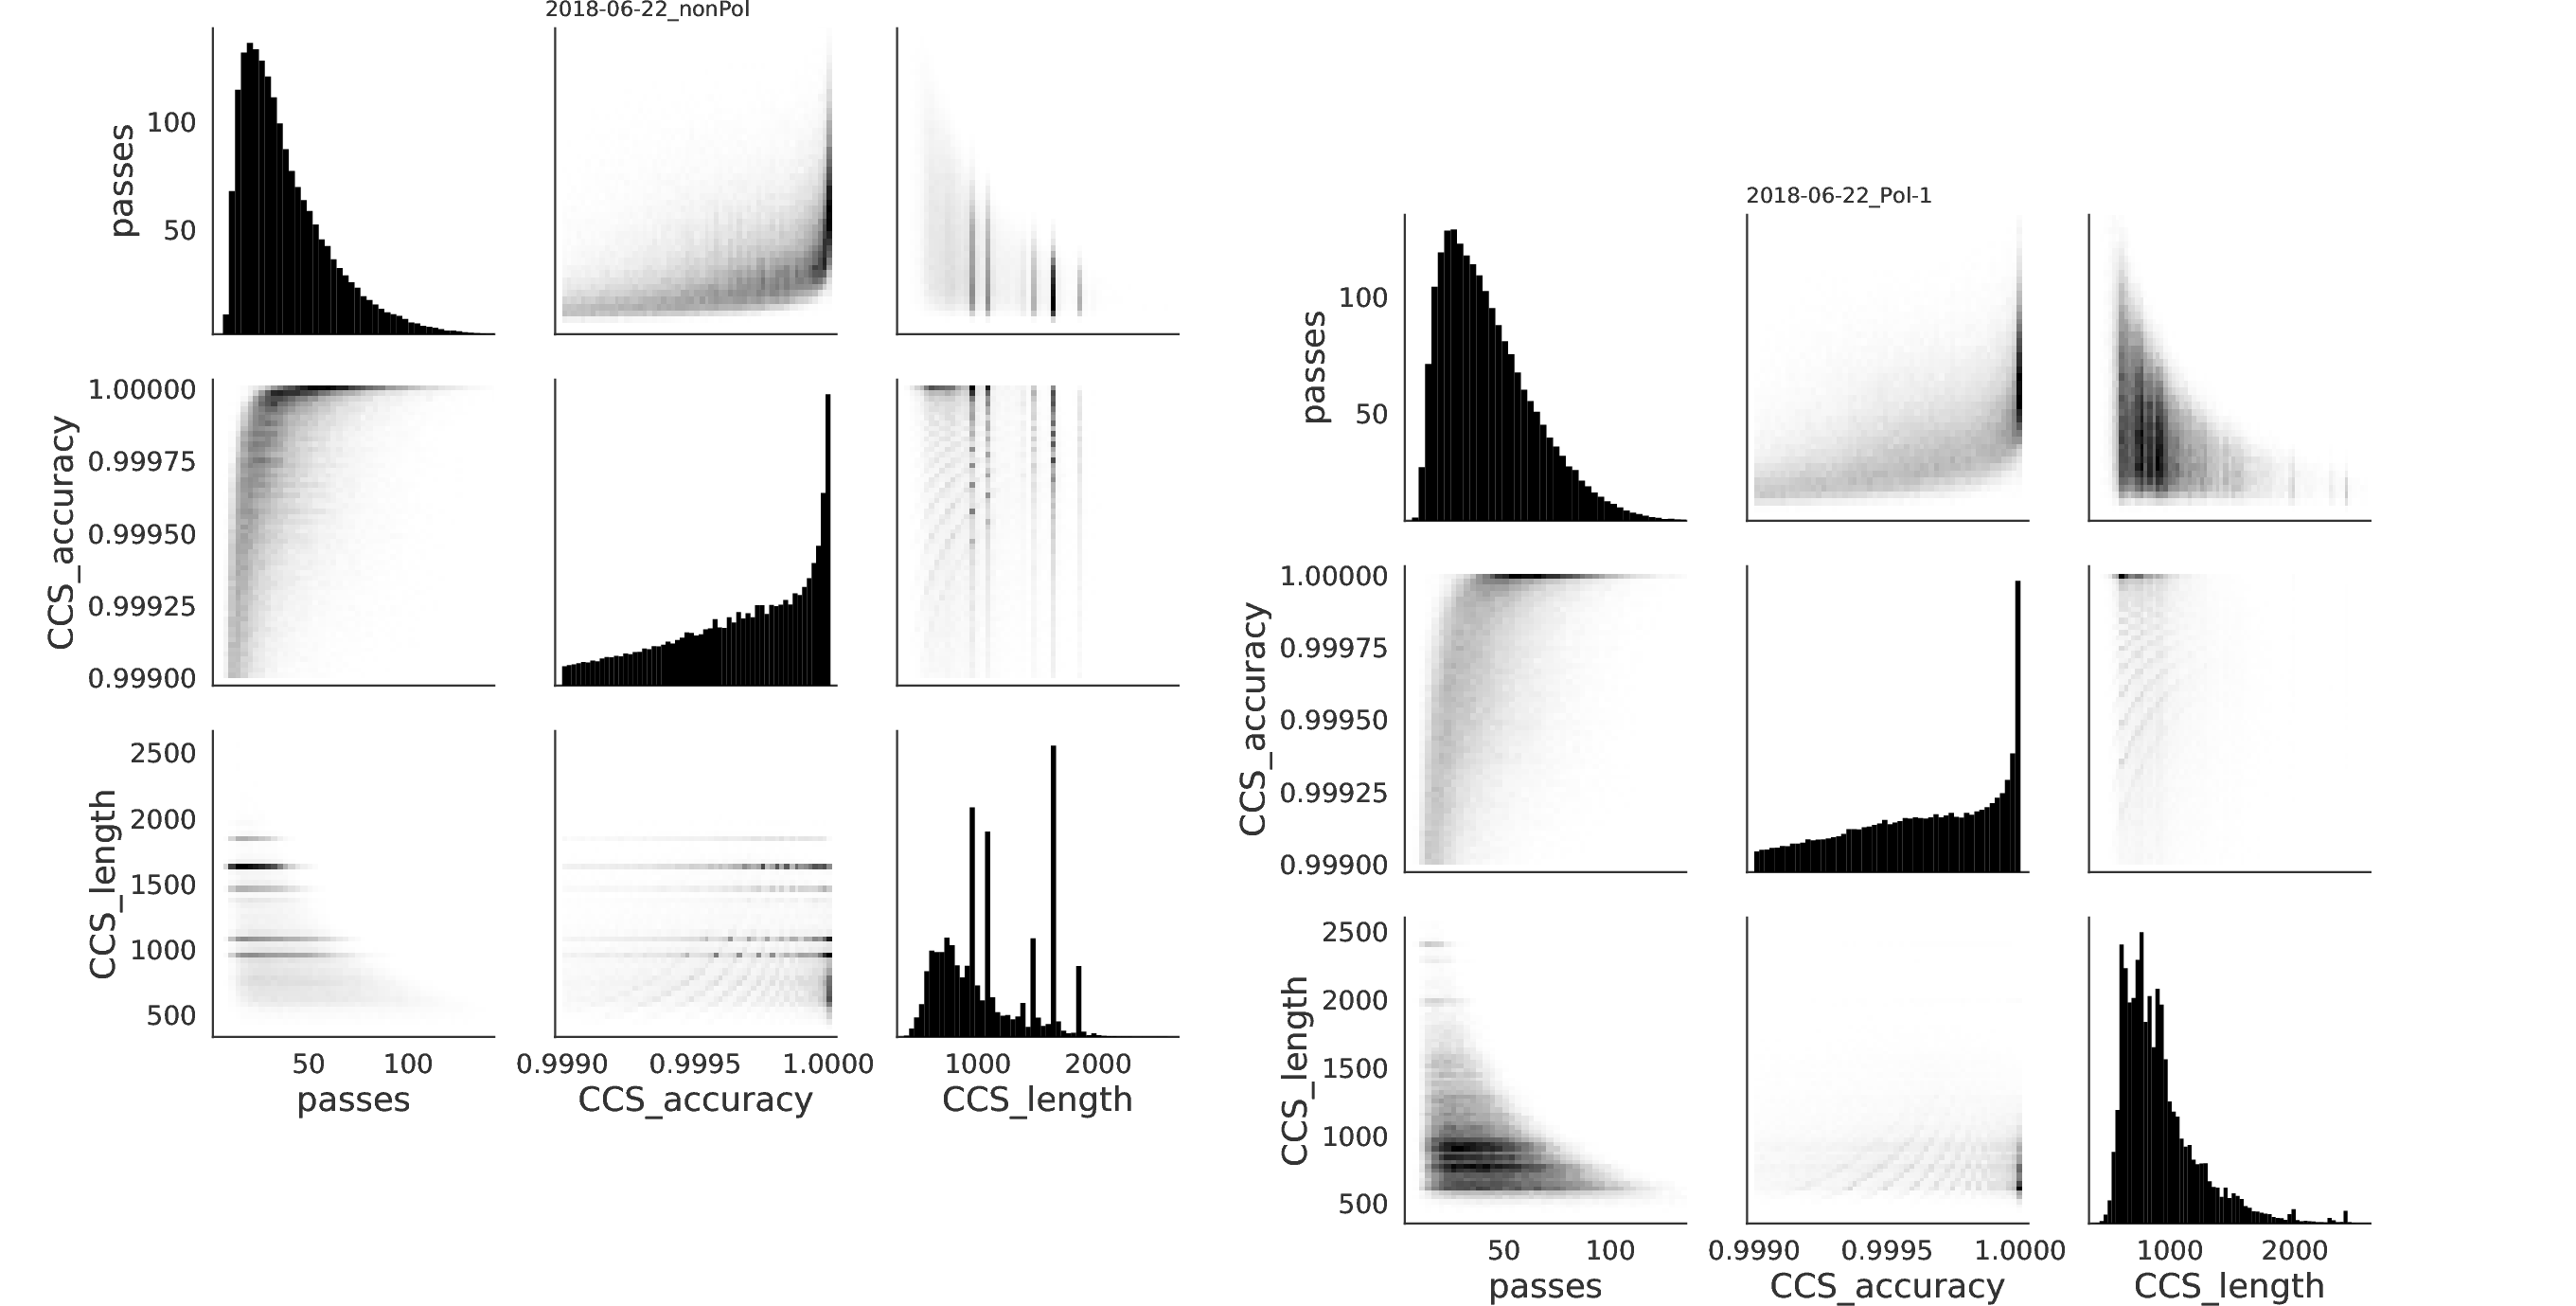

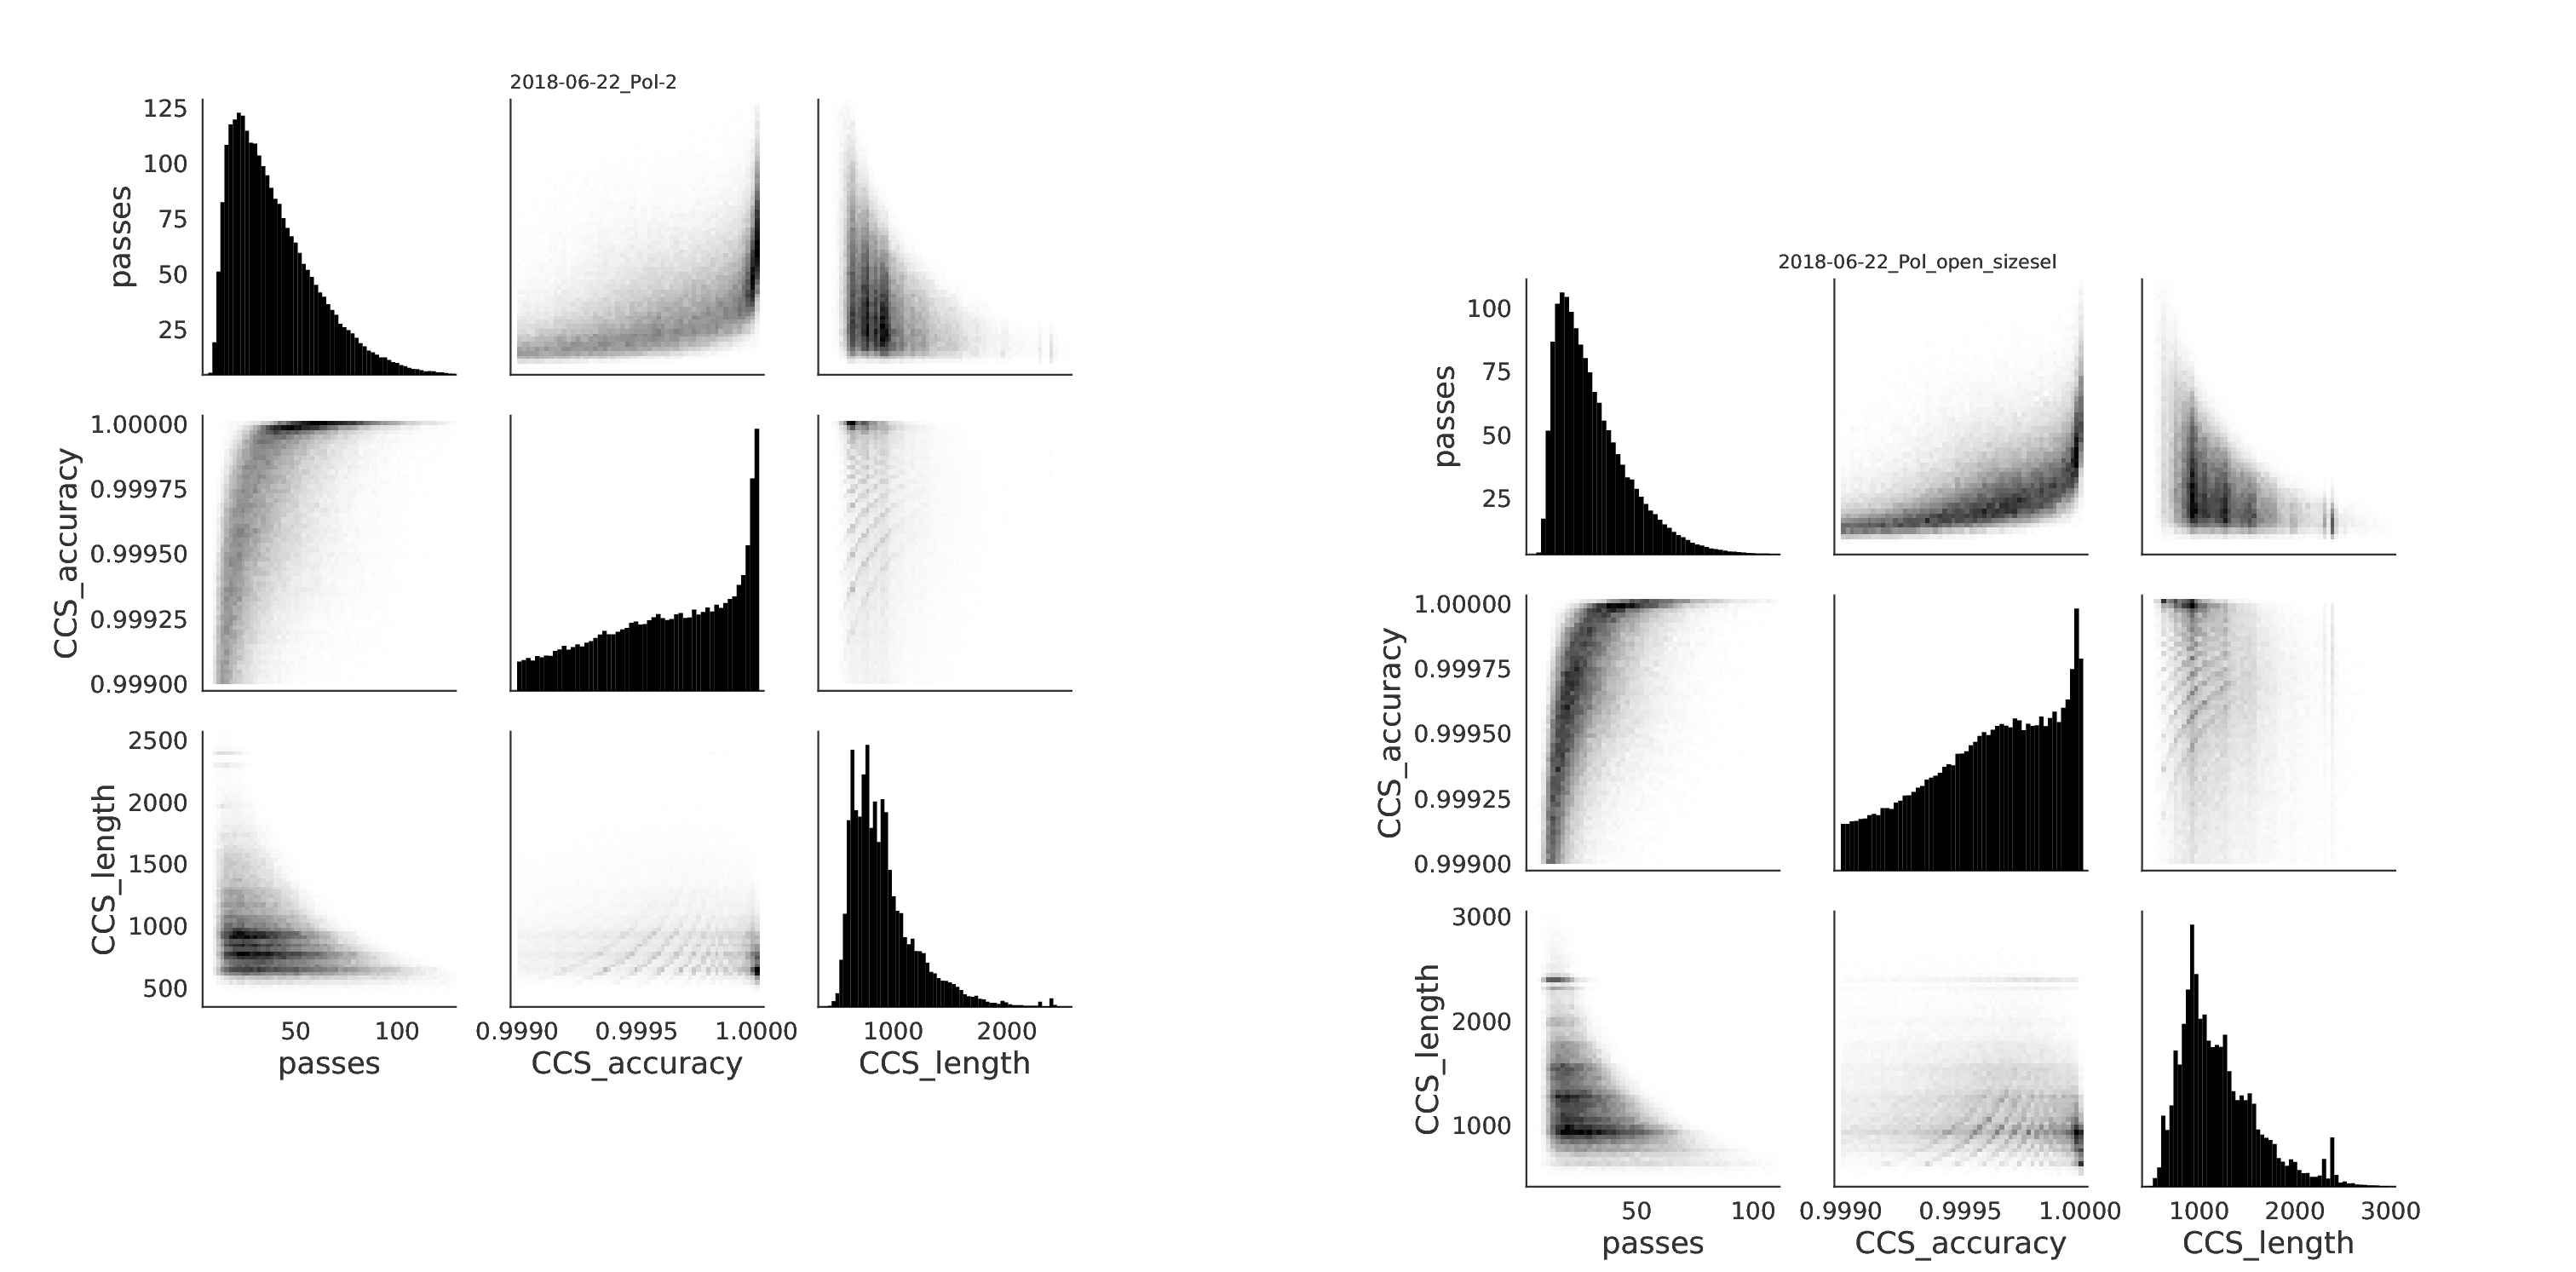

In [8]:
ccs_plots = []
for i, ccs in enumerate(ccslist):
    ccs_plot = os.path.join(ccsdir, '{0}_ccs_plot.pdf'.format(ccs.samplename))
    dms_tools2.plot.plotColCorrs(ccs.df, ccs_plot,
            ['passes', 'CCS_accuracy', 'CCS_length'], title=ccs.samplename)
    ccs_plots.append(ccs_plot)
    if (i + 1) % 2 == 0:
        showPDF(ccs_plots)
        ccs_plots = []

## Align CCSs to flu genes
The PacBio sequencing was performed on PCR-amplified product.
This PCR product was amplified off the 10X barcoded material using semi-specific PCR with one end specifically annealing to flu transcripts.
We want to identify the CCS's that represent properly barcoded 10X material from influenza genes, and then call the barcodes and align the barcoded mRNA to influenza transcripts.

### Barcoded CCS features
This [10X technical note](https://teichlab.github.io/scg_lib_structs/data/CG000108_AssayConfiguration_SC3v2.pdf) outlines the sequences appended by the v2 10X single-cell 3' kit used in these experiments. 
Specifically:

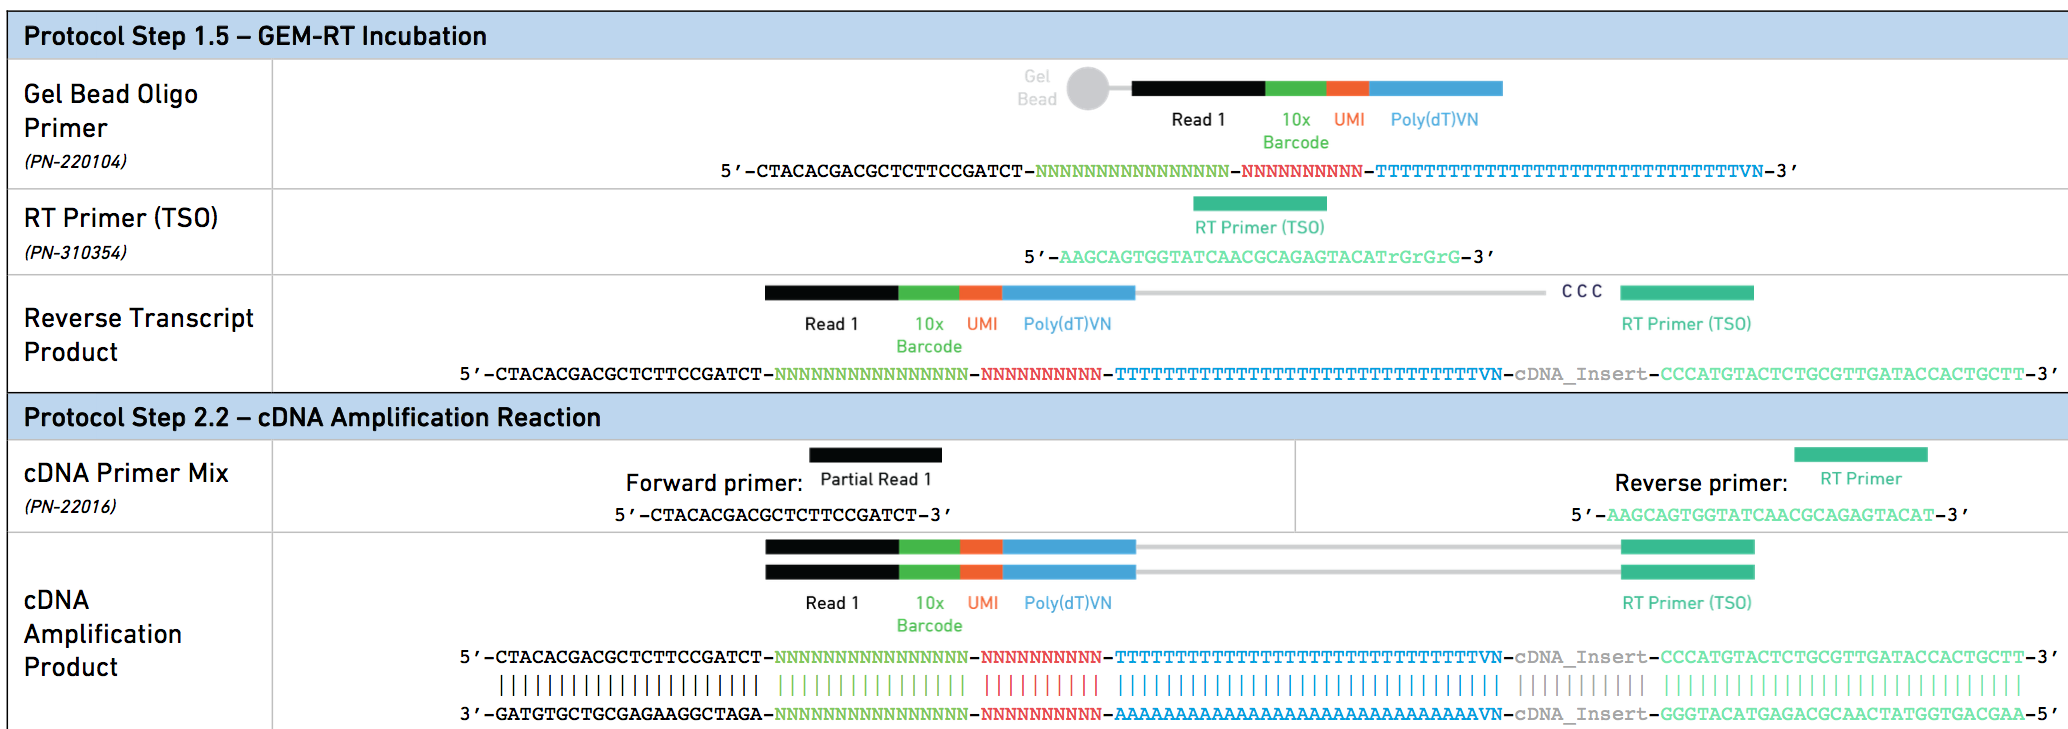

In [9]:
display(Image('./data/images/10xschematic.png'))

Zooming in on the 3' adaptor sequence, it is:
`CTACACGACGCTCTTCCGATCT-NNNNNNNNNNNNNNNN-NNNNNNNNNN-TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTVN` where the dash-delimited sequences are the read-1 priming site, the 16XN cell barcode, the 10XN UMI, the 30XT oligo-dT primer, followed by `V` (anything but `T`) and `N` (nominally, first nucleotide of upstream of mRNA polyA tail).

For the PCR to enrich the 10X product, Alistair used a 3' primer that anneals to this adaptor, namely:

In [10]:
primer3 = 'CTACACGACGCTCTTCCGATCT'
print("The length of the 3' primer is {0} nt".format(len(primer3)))

The length of the 3' primer is 22 nt


For the 5' primer, Alistair used a mix of primers that covered each of the 8 flu gene segments:

In [11]:
primer5_mix = {'PB2':'GCGAAAGCAGGTCAATTATATTCAATATGGAAAG',
               'PB1':'GCGAAAGCAGGCAAACCATTTG',
               'PA':'GCGAAAGCAGGTACTGATTCAAAATGG',
               'HA':'GCAAAAGCAGGGGAAAATAAAAACAACC',
               'NP':'GCAAAAGCAGGGTAGATAATCACTCAC',
               'NA':'GCGAAAGCAGGAGTTTAAATGAATCCAAAC',
               'M':'GCAAAAGCAGGTAGATATTGAAAGATGAGTC',
               'NS':'GCAAAAGCAGGGTGACAAAGACATAATG',
              }
print("The length of the 5' primer ranges from {0} to {1} nt".format(
        min(map(len, primer5_mix.values())), max(map(len, primer5_mix.values()))))

The length of the 5' primer ranges from 22 to 34 nt


### Flu alignment targets
We want to align the barcoded sequences to the flu mRNAs.
We will align to the wildtype flu sequences using a `dms_tools2.minimap2.Mapper`, and then call the synonymous barcodes using a `dms_tools2.minimap2.TargetVariants` object.
Both of these objects are initialized here.

The wildtype flu mRNA sequences are in [./data/flu_sequences/flu-wsn-mRNA.fasta](./data/flu_sequences/flu-wsn-mRNA.fasta), and the synonymous barcoded ones are in [./data/flu_sequences/flu-wsn-mRNA-double-syn.fasta](./data/flu_sequences/flu-wsn-mRNA-double-syn.fasta).
We want to align to the sequence **interior** to the primer binding sites defined above: the region between the custom 5' primer and the polyA tail.
We therefore read in the mRNAs, and then trim each from the 5' termini to the end of the primer binding site, and then write these to a file to use as the alignment targets:

In [12]:
# get the targets and synonymous-barcoded targets mRNAs
targets = collections.defaultdict(list)
for variant in ['', '-double-syn']:
    for full_mRNA in Bio.SeqIO.parse(
            './data/flu_sequences/flu-wsn{0}-mRNA.fasta'.format(variant), 'fasta'):
        full_mRNA_seq = str(full_mRNA.seq)
        primer = [p for p in primer5_mix.values() if full_mRNA_seq.count(p)]
        assert len(primer) == 1, "matched multiple primers in {0}".format(full_mRNA.name)
        targetseq = full_mRNA_seq[full_mRNA_seq.index(primer[0]) + len(primer[0]) : ]
        targets[variant].append((full_mRNA.name, targetseq))
        if not variant:
            print("Aligning to {0} nt region of {1}".format(len(targetseq), full_mRNA.name))

# write the targets to files
aligndir = os.path.join(pacbioresultsdir, 'alignments')
os.makedirs(aligndir, exist_ok=True)
targetfile = os.path.join(aligndir, 'targets.fasta')
with open(targetfile, 'w') as f:
    f.write('\n'.join('>{0}\n{1}'.format(*tup) for tup in targets['']))
syntargetfile = os.path.join(aligndir, 'targets-double-syn.fasta')
with open(syntargetfile, 'w') as f:
    f.write('\n'.join('>{0}\n{1}'.format(*tup) for tup in targets['-double-syn']))

# initialize mapper
mapper = dms_tools2.minimap2.Mapper(targetfile,
        dms_tools2.minimap2.OPTIONS_VIRUS_W_DEL,
        target_isoforms={'fluM1':['fluM2'], 'fluM2':['fluM1'],
                         'fluNS1':['fluNS2'], 'fluNS2':['fluNS1']})
print("\nPerforming alignments with minimap2 version {0}".format(mapper.version))

# initialize target variant caller
targetvariants = dms_tools2.minimap2.TargetVariants({'wildtype':targetfile,
        'synonymously barcoded':syntargetfile}, mapper, variantsites_min_acc=0.99)

Aligning to 2285 nt region of fluPB2
Aligning to 2297 nt region of fluPB1
Aligning to 2183 nt region of fluPA
Aligning to 1725 nt region of fluHA
Aligning to 1516 nt region of fluNP
Aligning to 1357 nt region of fluNA
Aligning to 973 nt region of fluM1
Aligning to 285 nt region of fluM2
Aligning to 839 nt region of fluNS1
Aligning to 367 nt region of fluNS2

Performing alignments with minimap2 version 2.10-r761


### Match and align CCSs
We use the function `dms_tools2.pacbio.matchAndAlignCCS` to go through the CCS's, find the ones that are "barcoded" (have the proper elements), and the align these barcoded genes.
All the results go into a pandas data frame called *df_ccs*.

Specifically, we look for CCS's that have:
  - Any 5' primer from Alistair's mix, trimmed a bit at the start since the first few nucleotides in the CCS might be off. We call this *termini5*.
  - The mRNA itself, which we call the *gene*. Since we define the polyA tail as beginning on the first `A` at the polyA signal, the gene must end on a non-`A` nucleotide (which is the IUPAC code `B`).
  - The polyA tail, which is effectively a spacer between the *gene* and the *UMI* / *barcode*. This tail is expected to be 30 `A`'s from 10X primer, but we allow it to be anything greater than 25 to account for the sloppiness in sequencing and primer synthesis associated with runs. We also use [regex fuzzy matching](https://stackoverflow.com/a/15975649) to allow the polyA to have up to two non-`A` nucleotides internal to it, since for instance the `VN` tooth in the oligo-dT primer might sometimes anneal in the wrong spot. We call this the *spacer* in the call to `dms_tools2.pacbio.matchAndAlignCCS`, but then rename to *polyA*.
  - The 10-nucleotide UMI from the 10X primer, which we call *UMI*.
  - The 16-nucleotide cell barcode from the 10X primer, which we call *barcode*.
  - The 3' primer that Alistair used, which anneals in the read 1 primer binding site on the 10X primer. We call this *termini3*.
  
Note also that in the call to `dms_tools2.pacbio.matchAndAlignCCS`, we specify that *M1* and *M2* are isoforms, and *NS1* and *NS2* are isoforms.
  
We don't require a match to the first 5 nt of each termini, as sometimes the ends of the CCS's can be "sloppy".

We use a `dms_tools2.minimap2.MutationCaller` to call mutations.
This calling is done in 1-based indexing of the target, and uses modest clipping of the target and soft clipping of the query to avoid calling mutations right at the ends.

In [13]:
trim_ends = 5 # trim this many off each termini

mutationcaller = dms_tools2.minimap2.MutationCaller(
        query_softclip=10, target_clip=20)

df_ccs = dms_tools2.pacbio.matchAndAlignCCS(
        ccslist=ccslist,
        mapper=mapper,
        termini5='|'.join([s[trim_ends : ] for s in primer5_mix.values()]),
        gene='N+B',
        spacer='AAA(A{19,}){e<=2}AAA', # regex fuzzy matching allows 2 mismatch
        umi='N{10}',
        barcode='N{16}',
        termini3=dms_tools2.utils.reverseComplement(primer3)[ : trim_ends],
        targetvariants=targetvariants,
        mutationcaller=mutationcaller
        ).rename(columns={'has_spacer':'has_polyA'})

print("Attempted to match and align all {0} CCSs".format(len(df_ccs)))

Attempted to match and align all 852352 CCSs


### Stats on matching / alignment
Below we analyze the statistics on the matching and aligning of the CCSs:

Here is a table of the matching / alignment statistics:


samplename,category,number of CCSs,percent
2017-06-08,total,18056,100
2017-06-08,has termini3,18050,99
2017-06-08,has polyA,16725,92
2017-06-08,has termini5,4246,23
2017-06-08,barcoded,3634,20
2017-06-08,gene aligned,3633,20
2017-06-08,CCS aligned,4453,24
2017-12-07,total,209830,100
2017-12-07,has termini3,209689,99
2017-12-07,has polyA,190652,90



Here is a plot of the results:


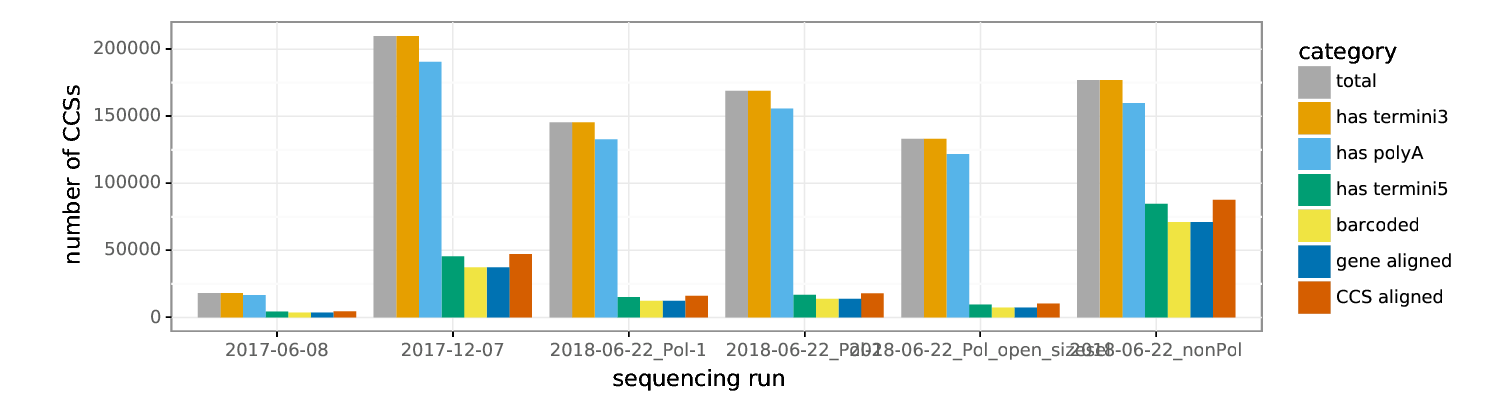

In [14]:
# possible matching / alignment categories
match_align_cats = ['total', 'has_termini3', 'has_polyA', 'has_termini5',
                    'barcoded', 'gene_aligned', 'CCS_aligned']

# tabulate statistics on matching / alignment
match_align_df = (
    df_ccs
    .assign(total=True)
    .melt(id_vars=['samplename'], 
          value_vars=match_align_cats,
          var_name='category',
          value_name='number of CCSs')
    .groupby(['samplename', 'category'], as_index=False)
    .aggregate('sum')
    .assign(category=lambda x: pandas.Categorical(
            x.category.str.replace('_', ' '), 
            [col.replace('_', ' ') for col in match_align_cats]))
    .sort_values(['samplename', 'category'])
    .assign(percent=lambda x: 100 * x['number of CCSs'] / 
               x.groupby('samplename')['number of CCSs'].transform('max'))
    )
print("Here is a table of the matching / alignment statistics:")
display(HTML(match_align_df.to_html(index=False, float_format='%d')))

# plot the matching alignment statistics
match_align_plot = os.path.join(aligndir, 'match_align_plot.pdf')
(ggplot(match_align_df, aes('samplename', 'number of CCSs')) +
    geom_bar(aes(fill='category'), position='dodge', stat='identity') +
    scale_fill_manual(COLOR_BLIND_PALETTE_GRAY) +
    xlab('sequencing run') 
    ).save(match_align_plot,
           width=1.5 * (1 + len(seqruns)),
           height=3)
print("\nHere is a plot of the results:")
showPDF(match_align_plot, width=700)

We see that across both samples, the vast majority of CCSs have the 3' termini and the polyA, as might be expected given that those need to be there for the 3' primer to work.

However, only a bit over 20% have the 5' termini.
This could be because only a small fraction of all sequences in the initial PCR template pool will be flu mRNAs with the right termini for the 5' primer, so there may be spurious amplification (by the 3' primer or just linear amplification product) that doesn't have the 5' termini.

Most of the CCSs that have the 5' termini are also *barcoded* in the sense that they fully match the expected patterns that allow us to call a barcode and UMI.

Of these *barcoded* CCSs, most of them have mRNA inserts ("genes") that align to the flu targets, and so are in the *gene aligned* category.

We also see that if we align the full CCS without requiring it to match the termini / barcode / polyA, we get a few more than for the *gene aligned* category, indicating that some of the CCSs for which we can't call barcodes still have flu in them.
These may have mutations in the termini / polyA, or they may be some sort of chimera.
In any case, since the *CCS aligned* category is only modestly larger than the *gene aligned* category, for all subsequent analyses we'll focus just on the *gene aligned* CCSs.

### Get CCSs with gene aligned
For the reasons explained immediately above, all remaining analyses will focus only on the CCSs in the *gene aligned* category.
So only keep these in our *df_ccs* data frame.

In [15]:
df_ccs = df_ccs.query('gene_aligned').reset_index(drop=True)

## Quality-control alignments
For the CCSs for which the gene insert aligned to flu, we now do some quality controlling on several important aspects.

We do this by adding a column to our data frame named `QC_filtered`.
Initially all entries in this columns are the string "passes_filters".
As we go through each filter in order below, we add a string describing the filtering reason for each CCS that fails that filter.
Once a CCS fails one filter (in the order they are provided below), we don't continue checking it against the other filters.

In [16]:
df_ccs['pass_QC'] = True
df_ccs['QC_fail_reason'] = 'passes_QC'

### Barcode accuracy
We want the barcodes called in the CCSs to be high accuracy. 
This might not be the case if molecules with different barcodes anneal during the PCR, such that a different barcode is sequenced on each strand of the SMRTbell that forms the CCS.
So we tabulate some statistics about the distribution of barcode accuracies among CCSs that pass our filters so far:

In [17]:
(df_ccs
    .query('pass_QC')
    .groupby('samplename')
    .barcode_accuracy
    .describe(percentiles=[0.001, 0.01, 0.02])
    )

,count,mean,std,min,0.1%,1%,2%,50%,max
samplename,,,,,,,,,
2017-06-08,3633.0,0.999863,0.001431,0.968363,0.979985,0.996868,0.999685,1.0,1.0
2017-12-07,37394.0,0.999962,0.000688,0.968675,0.987957,0.999822,0.999980,1.0,1.0
2018-06-22_Pol-1,12307.0,0.999939,0.000824,0.975059,0.984986,0.999482,0.999902,1.0,1.0
2018-06-22_Pol-2,13834.0,0.999952,0.000723,0.975118,0.987530,0.999504,0.999937,1.0,1.0
2018-06-22_Pol_open_sizesel,7338.0,0.999942,0.000865,0.975082,0.985385,0.999530,0.999901,1.0,1.0
2018-06-22_nonPol,71006.0,0.999913,0.001182,0.948912,0.980079,0.999009,0.999875,1.0,1.0


Below we see that the barcode accuracies are consistently very high, with over 98% having accuracies that exceed the accuracy threshold of 0.999 used when building the CCSs with PacBio's [ccs program](https://github.com/PacificBiosciences/unanimity/blob/develop/doc/PBCCS.md), and all of them having accuracies of >96%.
Just to be safe, we will filter for CCSs that have a barcode accuracy $\ge$0.999, which will eliminate only a very small fraction.

We not in the data frame which of the CCSs that have not already been filtered fail this barcode accuracy filter:

In [18]:
fail_index = df_ccs.query('pass_QC & (barcode_accuracy < 0.999)').index
df_ccs.loc[fail_index, 'pass_QC'] = False
df_ccs.loc[fail_index, 'QC_fail_reason'] = 'low barcode accuracy'

### Additional alignments
We want to get rid of CCSs that align to multiple different influenza genes.
The reason is that these probably represent some sort of PCR chimera / fusion during the library preparation.
Note that we are only looking at multiple alignments to different targets / isoforms (we specified that M1 / M2 and NS1 / NS2 are isoforms in the `target_isoforms` argument to the `dms_tools2.minimap2.Mapper`), so this will not purge alignments that involve the same gene (these could be complex deletions) or different splice forms.
First, we tabulate some statistics about the distribution of the number of additional alignments to different targets among CCSs that pass our filters so far:

In [19]:
(df_ccs
    .query('pass_QC')
    .groupby('samplename')
    .gene_aligned_n_additional_difftarget
    .describe(percentiles=[0.99, 0.999, 0.9999])
    )

,count,mean,std,min,50%,99%,99.9%,99.99%,max
samplename,,,,,,,,,
2017-06-08,3579.0,0.001397,0.037356,0.0,0.0,0.0,1.0,1.0000,1.0
2017-12-07,37202.0,0.001828,0.048602,0.0,0.0,0.0,1.0,2.0000,2.0
2018-06-22_Pol-1,12211.0,0.001474,0.042422,0.0,0.0,0.0,1.0,1.7790,2.0
2018-06-22_Pol-2,13742.0,0.001746,0.046693,0.0,0.0,0.0,1.0,2.0000,2.0
2018-06-22_Pol_open_sizesel,7285.0,0.001098,0.037036,0.0,0.0,0.0,0.0,1.2716,2.0
2018-06-22_nonPol,70315.0,0.002802,0.068554,0.0,0.0,0.0,1.0,2.0000,2.0


There are very few CCSs with additional alignments to other targets (less than 1%), and we remove them:

In [20]:
fail_index = df_ccs.query('pass_QC & gene_aligned_n_additional_difftarget').index
df_ccs.loc[fail_index, 'pass_QC'] = False
df_ccs.loc[fail_index, 'QC_fail_reason'] = 'aligns to multiple targets'

### Excessive alignment trimming
For perfect matches the of query CCSs to the target flu mRNAs, alignment of the query to the target is end-to-end, with no trimming of either the query or the target at either end.

However, in practice, in many cases there is trimming of the query or the target.
Here we QC filter based on the presence of excessive trimming.

#### Trimming of query start
Based on the way that the products were PCR-amplified, we expect the query starts to align exactly with the target start, so there shouldn't be any need for trimming.
Below are tabulated statistics about the distribution of trimming at the query start:

In [21]:
(df_ccs
    .query('pass_QC')
    .groupby('samplename')
    .gene_aligned_n_trimmed_query_start
    .describe(percentiles=[0.99, 0.999, 0.9999])
    )

,count,mean,std,min,50%,99%,99.9%,99.99%,max
samplename,,,,,,,,,
2017-06-08,3574.0,0.276721,15.792732,0.0,0.0,0.0,3.427,611.7110,944.0
2017-12-07,37154.0,0.214620,12.046754,0.0,0.0,0.0,3.000,594.7973,1092.0
2018-06-22_Pol-1,12197.0,0.102402,7.018676,0.0,0.0,0.0,3.000,363.9132,623.0
2018-06-22_Pol-2,13724.0,0.013480,0.692056,0.0,0.0,0.0,3.000,18.5540,75.0
2018-06-22_Pol_open_sizesel,7279.0,0.024591,1.078315,0.0,0.0,0.0,3.000,62.2722,63.0
2018-06-22_nonPol,70252.0,0.289558,16.076834,0.0,0.0,0.0,4.000,985.4227,1087.0


Most (>99%) queries align exactly with the target at their start, with no trimming. 
There are a few nucleotides trimmed from a modest fraction (<1%).
This modest trimming is explainable---the 5' primers are similar for the different flu genes, so there may occassionally be mis-priming so that the primer amplifies a different flu mRNA, which might lead to a bit of trimming at the very start of the alignment.
There are then a very small number (less than <0.01%) that have very large amounts trimmed.
We will discard CCSs with more than 5 nucleotides trimmed from the query start:

In [22]:
fail_index = df_ccs.query('pass_QC & (gene_aligned_n_trimmed_query_start > 5)').index
df_ccs.loc[fail_index, 'pass_QC'] = False
df_ccs.loc[fail_index, 'QC_fail_reason'] = 'excessive trimming of query start'

#### Trimming of target start
We also expect all of the alignments to start exactly at the begin of the target, because the PCR-amplification should lead to this.
Below are tabulated statistics about the distribution of trimming at the target start:

In [23]:
(df_ccs
    .query('pass_QC')
    .groupby('samplename')
    .gene_aligned_n_trimmed_target_start
    .describe(percentiles=[0.99, 0.999, 0.9999])
    )

,count,mean,std,min,50%,99%,99.9%,99.99%,max
samplename,,,,,,,,,
2017-06-08,3572.0,0.292553,16.122512,0.0,0.0,0.0,3.0,638.1103,962.0
2017-12-07,37131.0,0.083327,10.276784,0.0,0.0,0.0,3.0,17.4890,1702.0
2018-06-22_Pol-1,12191.0,0.126897,13.160668,0.0,0.0,0.0,4.0,4.0000,1453.0
2018-06-22_Pol-2,13721.0,0.004664,0.120646,0.0,0.0,0.0,3.0,4.0000,4.0
2018-06-22_Pol_open_sizesel,7276.0,0.004398,0.118327,0.0,0.0,0.0,2.0,4.0000,4.0
2018-06-22_nonPol,70192.0,0.202972,13.522500,0.0,0.0,0.0,3.0,979.3956,1232.0


This distribution looks very similar to that for trimming of the query starts immediately above, and (for the same logic explained there), we will discard CCSs with more than 5 nucleotides trimmed from the target start:

In [24]:
fail_index = df_ccs.query('pass_QC & (gene_aligned_n_trimmed_target_start > 5)').index
df_ccs.loc[fail_index, 'pass_QC'] = False
df_ccs.loc[fail_index, 'QC_fail_reason'] = 'excessive trimming of target start'

#### Trimming query ends
We expect the queries to end at the end of the target, and so there to be no clipping of the query ends. 
There are three plausible reasons for clipping of the query ends:
  1. A PCR artifact that leads to fusion of a flu gene with a cellular gene. We tried to filter out fusions of two different flu genes above by removing CCSs with additional alignments to a different flu target, but that filter won't remove fusions to things that aren't flu genes--although these are expected to be much more abundant. We would like to filter CCSs for which this occurs.
  2. The transcription of the mRNA from the query continuing past the polyA tail, or the polyA tail not be fully trimmed and removed. We might want to retain these. However, we expect the extension that has tobe trimmed in this case to be small, probably less than 50 nt.
  3. There is an internal deletion and for whatever reason the mapping failed to handle it properly and just trimmed the region after the deletion. We want to keep these. We would expect them to align with "additional alignments" since the trimmed region should be in a different alignment.
  
Below we tabulate some statistics on the distribution of trimming, for CCSs both with and without additional alignments (these distributions are hard to plot since they are so skewed):

In [25]:
(df_ccs
    .query('pass_QC')
    .assign(has_additional_alignment=lambda x: x.gene_aligned_n_additional > 0)
    .groupby(['samplename', 'has_additional_alignment'])
    .gene_aligned_n_trimmed_query_end
    .describe(percentiles=[0.9, 0.95, 0.98, 0.99, 0.999])
    )

count       mean  \
samplename                  has_additional_alignment                       
2017-06-08                  False                      2340.0   7.369658   
                            True                       1230.0   9.127642   
2017-12-07                  False                     33666.0   9.999198   
                            True                       3461.0  11.615140   
2018-06-22_Pol-1            False                     12133.0  12.339735   
                            True                         57.0  11.877193   
2018-06-22_Pol-2            False                     13660.0  12.417862   
                            True                         61.0  17.163934   
2018-06-22_Pol_open_sizesel False                      7239.0   9.880923   
                            True                         37.0  12.162162   
2018-06-22_nonPol           False                     41368.0   4.433209   
                            True                      28804.0   8.635849   

                                                            std  min  50%  \
samplename                  has_additional_alignment                        
2017-06-08                  False                     49.645995  0.0  1.0   
                            True                      39.958532  0.0  1.0   
2017-12-07                  False                     46.517989  0.0  1.0   
                            True                      40.084792  0.0  1.0   
2018-06-22_Pol-1            False                     52.328529  0.0  1.0   
                            True                      32.586736  0.0  1.0   
2018-06-22_Pol-2            False                     53.477853  0.0  1.0   
                            True                      60.699308  0.0  2.0   
2018-06-22_Pol_open_sizesel False                     53.003638  0.0  1.0   
                            True                      48.081825  0.0  1.0   
2018-06-22_nonPol           False                     27.545243  0.0  1.0   
                            True                      46.481467  0.0  1.0   

                                                       90%   95%     98%  \
samplename                  has_additional_alignment                       
2017-06-08                  False                      8.0  29.0   61.22   
                            True                      27.0  50.1   71.00   
2017-12-07                  False                     28.0  54.0   82.00   
                            True                      39.0  63.0   96.80   
2018-06-22_Pol-1            False                     41.0  66.0   96.36   
                            True                      37.0  43.2   86.24   
2018-06-22_Pol-2            False                     41.0  65.0   94.00   
                            True                      24.0  71.0  257.40   
2018-06-22_Pol_open_sizesel False                     26.0  49.0   78.00   
                            True                      10.4  44.8  134.52   
2018-06-22_nonPol           False                      3.0  22.0   51.00   
                            True                      21.0  43.0   71.00   

                                                         99%    99.9%     max  
samplename                  has_additional_alignment                           
2017-06-08                  False                      88.00  736.084  1161.0  
                            True                       85.42  549.055  1028.0  
2017-12-07                  False                     102.00  840.695  1799.0  
                            True                      128.40  600.780  1009.0  
2018-06-22_Pol-1            False                     116.68  904.604  1912.0  
                            True                      147.88  211.888   219.0  
2018-06-22_Pol-2            False                     115.00  979.069  1665.0  
                            True                      321.00  356.100   360.0  
2018-06-22_Pol_open_sizesel False              

We see that the distributions don't look much different between CCSs with and without additional alignments, so the internal deletion explanation doesn't appear to explain most of the clipping.
We will discard CCSs with more than 50 nt of trimming at the query end as almost certainly spurious, but keep those with less than 50 nt in case there is transcription past the polyA and/or problems calling the polyA.
Looking at the table above, we can see that this means we are discarding about 5% of the CCSs:

In [26]:
fail_index = df_ccs.query('pass_QC & (gene_aligned_n_trimmed_query_end > 50)').index
df_ccs.loc[fail_index, 'pass_QC'] = False
df_ccs.loc[fail_index, 'QC_fail_reason'] = 'excessive trimming of query end'

#### Trimming target ends
If transcription proceeds all the way to the target end, there should also not be trimming of the target ends.
Here are some actual tabulated statistics:

In [27]:
(df_ccs
    .query('pass_QC')
    .groupby('samplename')
    .gene_aligned_n_trimmed_target_end
    .describe(percentiles=[0.9, 0.95, 0.98, 0.99, 0.999])
    )

,count,mean,std,min,50%,90%,95%,98%,99%,99.9%,max
samplename,,,,,,,,,,,
2017-06-08,3445.0,62.555878,274.415905,0.0,1.0,6.0,473.0,1175.88,1735.0,1775.112,1782.0
2017-12-07,35030.0,153.003454,472.874739,0.0,0.0,328.1,1735.0,1771.00,1775.0,1882.000,2057.0
2018-06-22_Pol-1,11240.0,309.873221,639.109357,0.0,0.0,1731.0,1737.0,1773.00,1774.0,1873.610,1886.0
2018-06-22_Pol-2,12677.0,307.924824,637.961692,0.0,0.0,1731.0,1737.0,1773.00,1774.0,1876.000,1882.0
2018-06-22_Pol_open_sizesel,6941.0,271.853767,580.205554,0.0,0.0,1557.0,1701.0,1771.00,1774.0,1782.000,1877.0
2018-06-22_nonPol,68306.0,38.056525,158.281873,0.0,1.0,8.0,388.0,482.80,861.0,1190.780,1773.0


We see that in reality there is quite a bit of trimming of the target ends in 5-10% of CCSs.
However, there is a legitimate possible explanation: premature poly-adenylation of the flu transcripts leading to truncation of the query, or some form of internal deletion in the vRNA moving the polyA signal up in the transcript.
Since both of these seem plausible, for now we do not do any filtering based on the trimming of the target ends.

### Get QC-ed alignments
Now we tabulate the number of alignments that failed QC for each reason:

In [28]:
(df_ccs
    .assign(number=1)
    .groupby(['samplename', 'pass_QC', 'QC_fail_reason'])
    [['number']]
    .agg('count')
    )

number
samplename                  pass_QC QC_fail_reason                            
2017-06-08                  False   aligns to multiple targets               5
                                    excessive trimming of query end        125
                                    excessive trimming of query start        2
                                    excessive trimming of target start       2
                                    low barcode accuracy                    54
                            True    passes_QC                             3445
2017-12-07                  False   aligns to multiple targets              48
                                    excessive trimming of query end       2097
                                    excessive trimming of query start       23
                                    excessive trimming of target start       4
                                    low barcode accuracy                   192
                            True    passes_QC                            35030
2018-06-22_Pol-1            False   aligns to multiple targets              14
                                    excessive trimming of query end        950
                                    excessive trimming of query start        6
                                    excessive trimming of target start       1
                                    low barcode accuracy                    96
                            True    passes_QC                            11240
2018-06-22_Pol-2            False   aligns to multiple targets              18
                                    excessive trimming of query end       1044
                                    excessive trimming of query start        3
                                    low barcode accuracy                    92
                            True    passes_QC                            12677
2018-06-22_Pol_open_sizesel False   aligns to multiple targets               6
                                    excessive trimming of query end        335
                                    excessive trimming of query start        3
                                    low barcode accuracy                    53
                            True    passes_QC                             6941
2018-06-22_nonPol           False   aligns to multiple targets              63
                                    excessive trimming of query end       1866
                                    excessive trimming of query start       60
                                    excessive trimming of target start      20
                                    low barcode accuracy                   691
                            True    passes_QC                            68306

As the table above shows, less than 10% of the alignments fail the filters, and most of the failures are due to excessive trimming of the query end.

We keep just the QC-ed aligned CCSs for subsequent work:

In [29]:
df_ccs = df_ccs.query('pass_QC')

## Summary of QC-ed alignments
We are now going to analyze how many QC-ed alignments we have for each gene, and the length distribution of these alignments.

First, make the aligned genes a categorical variable so gene names are displayed in the desired order:

In [30]:
targetnames = list(mapper.targetseqs.keys())
df_ccs.gene_aligned_target = pandas.Categorical(
        df_ccs.gene_aligned_target, targetnames)

### Number of alignments per gene
Now we examine the number of QC-ed aligned CCSs for each gene.
We do this both aggregating over all sequencing runs and looking at the runs individually:


Number of alignments, all runs:


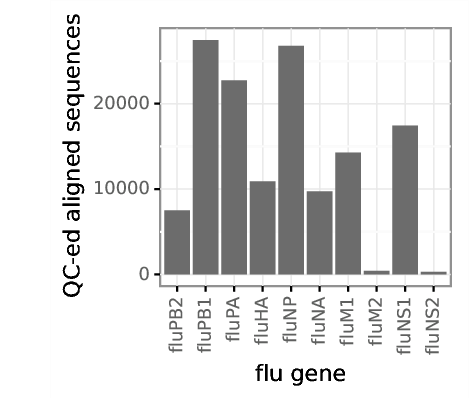


Number of alignments, by run:


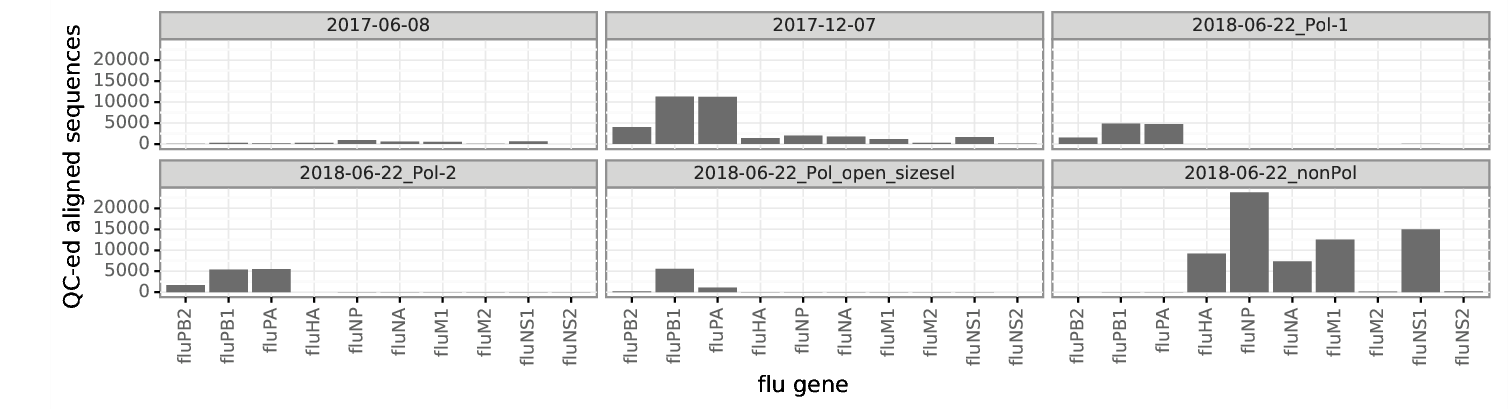

In [31]:
# base plot of number of sequences per gene
plot_nseqs = (
    ggplot(df_ccs, aes('gene_aligned_target')) +
        geom_bar() +
        theme(axis_text_x=element_text(angle=90, hjust=0.5)) +
        xlab("flu gene") +
        ylab("QC-ed aligned sequences")
    )

# plot total for all runs and by run
for plottype, facet, n in [
        ('all_runs', geom_blank(), 1),
        ('by_run', facet_wrap('~samplename'), len(seqruns))]:
    print("\nNumber of alignments, {0}:".format(plottype.replace('_', ' ')))
    nseqs_plot = os.path.join(aligndir, 'nsequences_{0}.pdf'.format(plottype))
    (plot_nseqs + facet).save(nseqs_plot, height=2.5, width=0.8 + 2 * n)
    showPDF(nseqs_plot, width=80 + 200 * n)

The plots above show that in total we have many more alignments for the polymerase genes, mostly due to the 2017-12-07 run being highly biased towards these genes.
This is because whereas the first run tried to amplify everything equally, the second run overloaded PB2 / PB1 / PA because they were much rarer in the first run.
But see the caveat about deletions that becomes apparent below...

Also, we see that there are many fewer alignments for M2 than M1, and for NS2 than NS1. 
This is as expected based on the known ratios of these splice forms.

### Distribution of alignment lengths
Not all of the alignments necessarily cover the entire gene, as there are often deletions in flu segments and can in principle also be insertions.
So we also plot the distribution of alignments by length for each segment, where we define the *alignment length* as the total number of aligned nucleotides, which can be either identities or mismatches (but not indels).
Note that each subplot below is shown with **its own y-axis**, so the plots show the distribution of lengths within each gene / sequencing run, but not the relative numbers of alignments across them:


Alignment lengths, all runs:


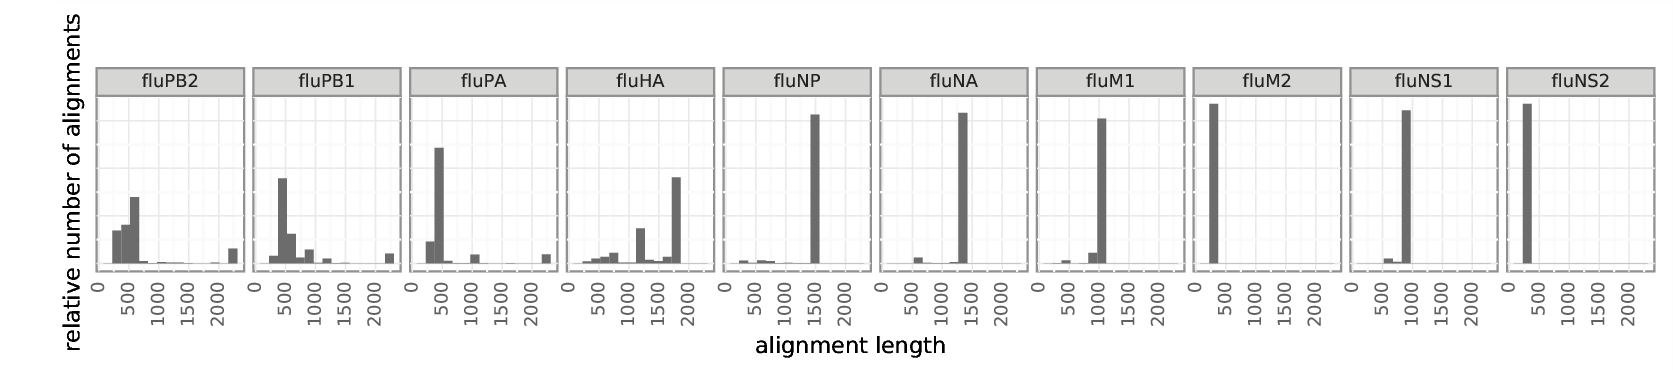


Alignment lengths, by run:


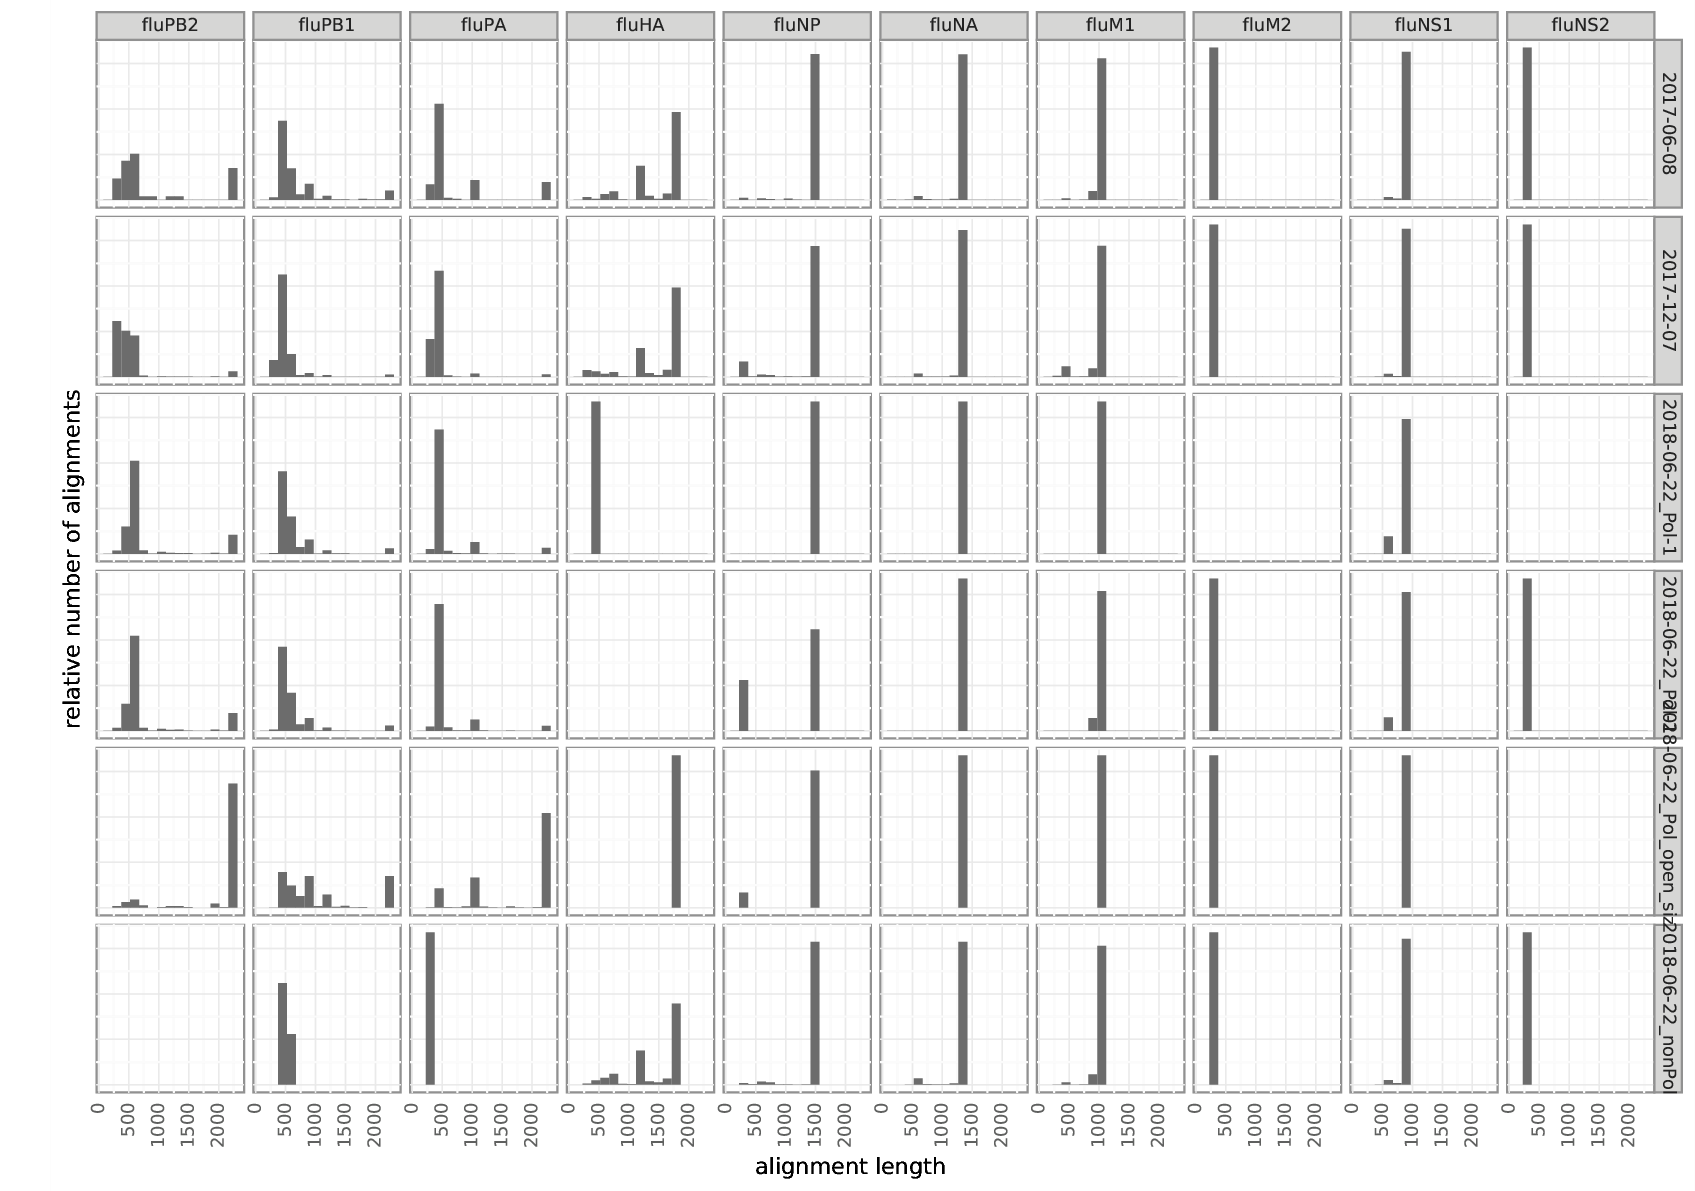

In [32]:
# add columnn with alignment lengths
df_ccs['alignment_length'] = df_ccs.gene_aligned_cigar.apply(
        dms_tools2.minimap2.numAligned)

# base plot of alignment lengths
plot_align_len = (
    ggplot(df_ccs, aes('alignment_length')) +
        geom_histogram(aes(x='alignment_length', y='..density..'), bins=15) +
        theme(axis_text_x=element_text(angle=90, hjust=0.5),
              axis_text_y=element_blank(), axis_ticks=element_blank()) +
        ylab("relative number of alignments") +
        xlab("alignment length")
        )

# plot for all runs and by run
for plottype, facet, n in [
        ('all_runs', facet_wrap('~ gene_aligned_target', nrow=1), 1),
        ('by_run', facet_grid('samplename ~ gene_aligned_target'), len(seqruns))]:
    print("\nAlignment lengths, {0}:".format(plottype.replace('_', ' ')))
    align_len_plot = os.path.join(aligndir, 'alignment_len_{0}.pdf'.format(plottype))
    (plot_align_len + facet).save(align_len_plot, width=15, height=1.7 * n)
    showPDF(align_len_plot)

As can be seen above, for most genes the alignments are strongly peaked at the length expected for the full-length gene.
But for the polymerase genes (PB2, PB1, and PA), most of the reads are actually deletions that are much smaller than the full-length size.
For HA, there are also prominent peaks at smaller sizes.

The enrichment of deletions for the polymerase probably exceed the actual biological frequency of these, and might also be due to amplification bias that prefers shorter segments during PCR.

### Near full-length alignments
Given the plots above that show that for some genes, many of the alignments are for partially deleted genes, we also plot the number "near full-length" alignments.
We define an alignment as "full-length" if the alignment length (as defined immediately above) is no more than 20 nucleotides less than the expected length of the alignment target.


Number of alignments, all runs:


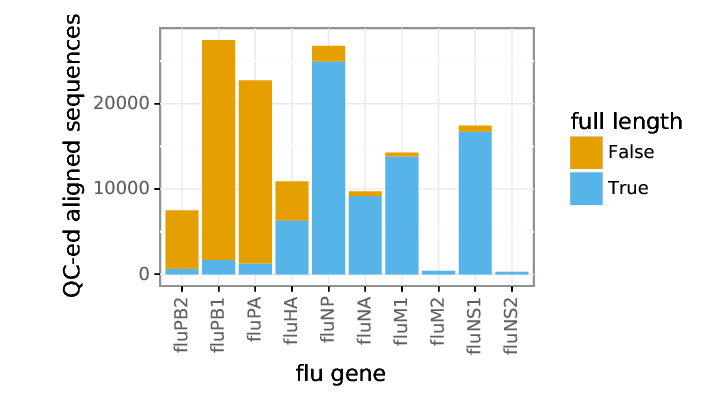


Number of alignments, by run:


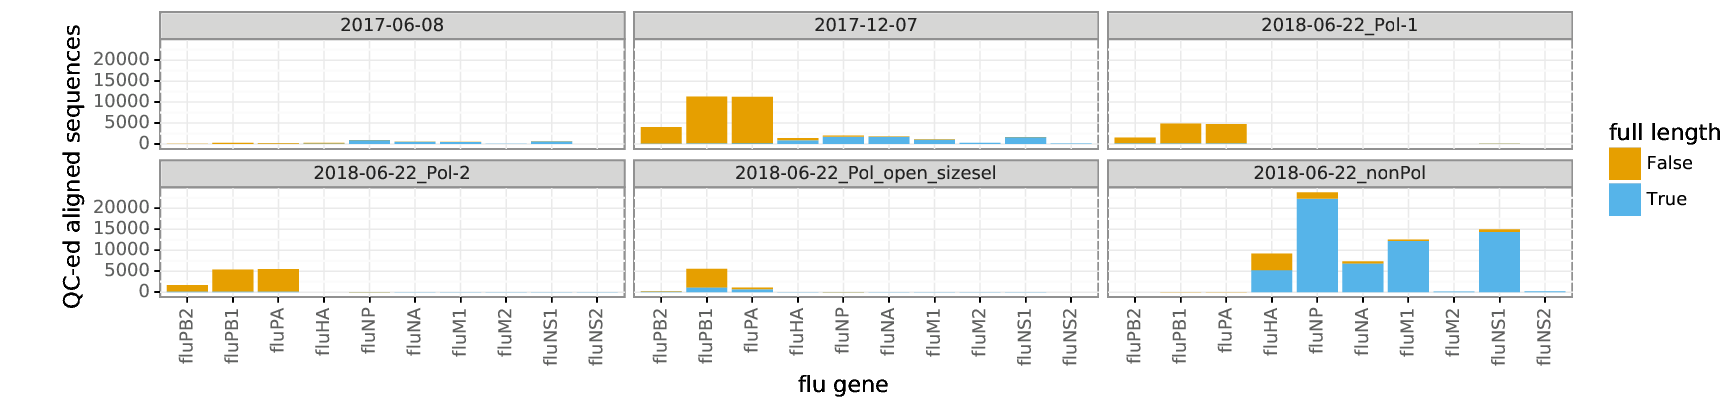

In [33]:
# assign target lengths and near full-length status
target_lengths = {name:len(seq) for name, seq in mapper.targetseqs.items()}
df_ccs = (
    df_ccs
    .assign(target_length=lambda x: x.gene_aligned_target.map(target_lengths))
    .assign(full_length=lambda x: (x.target_length <= 20 + x.alignment_length))
    )

plot_nseqs_full = (
    ggplot(df_ccs, aes('gene_aligned_target')) +
        geom_bar(aes(fill='full_length')) +
        theme(axis_text_x=element_text(angle=90, hjust=0.5)) +
        xlab("flu gene") +
        ylab("QC-ed aligned sequences") +
        scale_fill_manual(COLOR_BLIND_PALETTE_GRAY[1 : ],
                          name='full length')
    )

# plot total for all runs and by run
for plottype, facet, n in [
        ('all_runs', geom_blank(), 1),
        ('by_run', facet_wrap('~samplename'), len(seqruns))]:
    print("\nNumber of alignments, {0}:".format(plottype.replace('_', ' ')))
    nseqs_plot = os.path.join(aligndir, 'nsequences_full_len_{0}.pdf'.format(plottype))
    (plot_nseqs_full + facet).save(nseqs_plot, height=2.5, width=2 * (n + 0.8))
    showPDF(nseqs_plot, width=220 * (n + 0.8))

We see basically what is expected from the sets of plots in the previous two subsections.
Although we have many alignments for the polymerase genes, these are highly biased towards short fragments.
We have fairly good coverage of full-length segments for all other genes except the polymerase.
Note that the we have relatively little for M2 / NS2, but these sequences are contained within the M1 / NS1, so it's probably OK to have less for these.

### Passes/accuracy for alignments
Back at the initial running of `ccs`, we set thresholds for how many passes of sequencing and the minimum accuracy required for our CCSs.
Are these limiting?
For instance, when we look at the full-length alignments of the long polymerase genes, are we losing lots of sequences because of overly stringent thresholds?
We can address this by looking at the actual distribution of number of passes and CCS accuracy for our QC-ed aligned genes, both for full-length and non-full-length (e.g., with deletions) viral genes.
Below we plot these, using dashed green lines to show the minimum cutoffs:

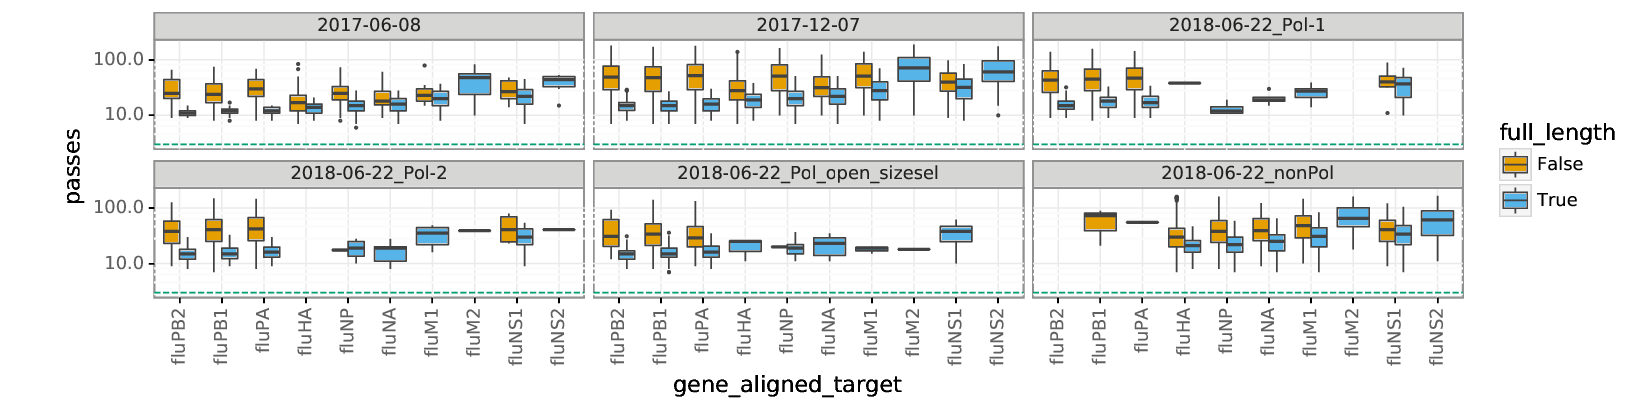

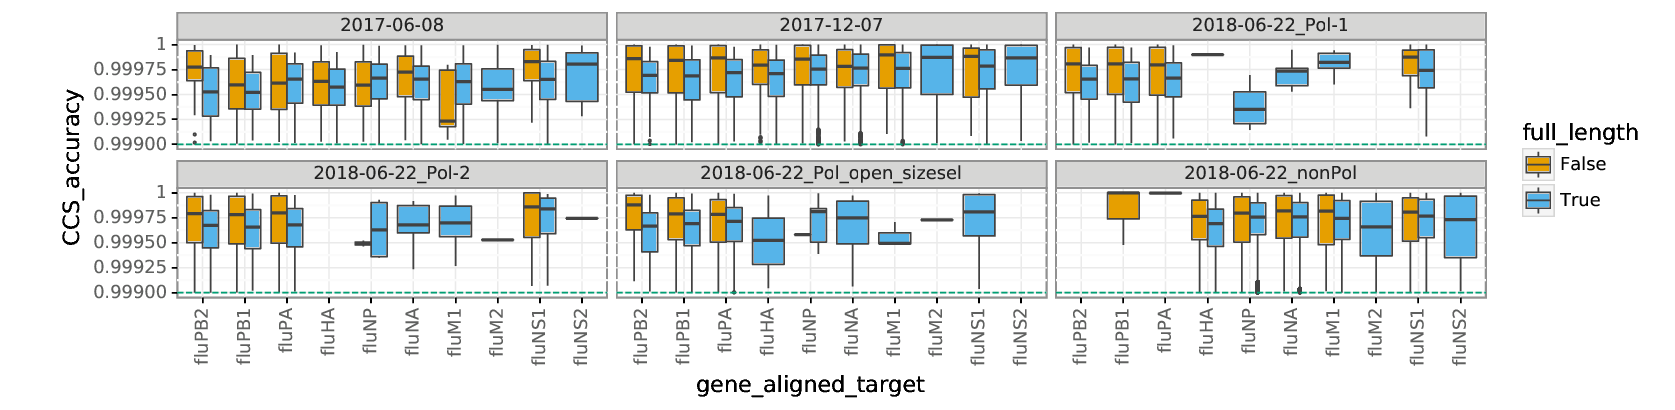

In [34]:
npasses_plot = os.path.join(aligndir, 'npasses.pdf')
(ggplot(df_ccs, aes('gene_aligned_target', 'passes', fill='full_length')) +
    geom_boxplot(outlier_size=0.2) +
    scale_y_log10(limits=(minpasses, df_ccs.passes.max())) +
    scale_fill_manual(COLOR_BLIND_PALETTE_GRAY[1 : ]) +
    facet_wrap('~ samplename') +
    theme(axis_text_x=element_text(angle=90, hjust=0.5)) +
    geom_hline(yintercept=minpasses, linetype='dashed',
        color=COLOR_BLIND_PALETTE_GRAY[3])
    ).save(npasses_plot, height=2.5, width=1.8 * (1 + len(seqruns)))
showPDF(npasses_plot, width=250 * (1 * len(seqruns)))

error_rate_plot = os.path.join(aligndir, 'error_rate.pdf')
(ggplot(df_ccs, aes('gene_aligned_target', 'CCS_accuracy', fill='full_length')) +
    geom_boxplot(outlier_size=0.2) +
    scale_y_continuous(limits=(minaccuracy, 1)) +
    scale_fill_manual(COLOR_BLIND_PALETTE_GRAY[1 : ]) +
    facet_wrap('~ samplename') +
    theme(axis_text_x=element_text(angle=90, hjust=0.5)) +
    geom_hline(yintercept=minaccuracy, linetype='dashed',
        color=COLOR_BLIND_PALETTE_GRAY[3])
    ).save(error_rate_plot, height=2.5, width=1.8 * (1 + len(seqruns)))
showPDF(error_rate_plot, width=250 * (1 * len(seqruns)))

As is apparent from these plots, the vast majority of sequences are well above both minimum thresholds.
Although the full-length polymerase genes do tend to have less passes and lower accuracy, most of them are still well above the threshold.
This suggests that we are **not** losing lots of fairly good sequences to overly stringent thresholds.

## Analyze viral barcodes
Each viral gene is either fully wildtype or "doubly synonymously barcoded" by a pair of synonymous mutations near each termini.
Note that these viral barcodes are distinct from the cell barcodes added by the 10X system.
These viral barcodes were called during the alignment using the `dms_tools2.minimap2.TargetVariants` initialized above.

Here we examine these barcodes. 
The most important reason to do this is to test for strand exchange during PCR, or pairing of different variants into the same dsDNA molecule during library preparation.
These would manifest as CCSs in which the different ends are assigned to different viral barcode variants, or in which the viral barcode sites are low accuracy.

### Inspect viral barcodes by gene
First we just plot the viral barcodes that are called for each gene in each sequencing run.
This plot is below.
In addition to faceting on sequencing run, we also facet on all QC-ed aligned sequences, and just those that correspond to full-length viral genes.

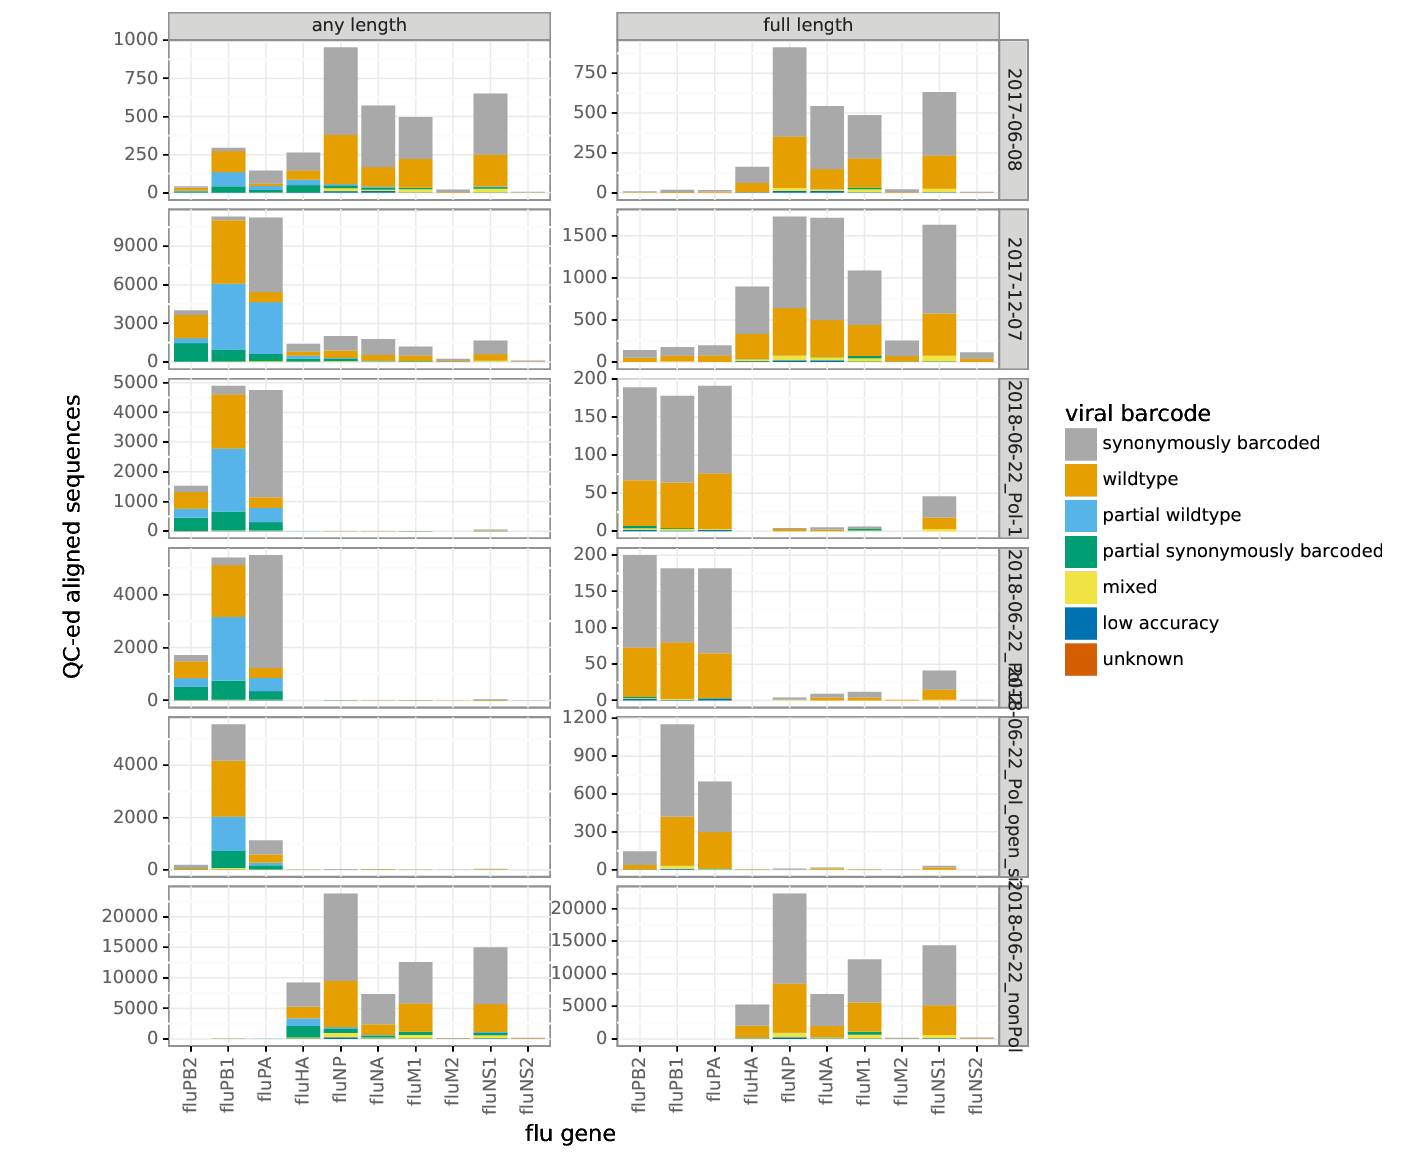

In [35]:
# create a directory for the CCS analysis
analysisdir = os.path.join(pacbioresultsdir, 'variant_and_mutation_analysis')
os.makedirs(analysisdir, exist_ok=True)

# order viral barcode categories from most to least for plotting
viralbarcode_cats = (
    df_ccs
    .groupby(['gene_aligned_target_variant'])
    .CCS
    .agg('count')
    .sort_values(ascending=False)
    .index
    )
df_ccs['gene_aligned_target_variant'] = pandas.Categorical(
        df_ccs['gene_aligned_target_variant'], viralbarcode_cats)

viralbarcode_plot = os.path.join(analysisdir, 'viralbarcodeplot.pdf')
(ggplot(pandas.concat([
            df_ccs.assign(full_length='any length'),
            df_ccs.query('full_length').assign(full_length='full length')]),
        aes('gene_aligned_target')) +
    geom_bar(aes(fill='gene_aligned_target_variant')) +
    facet_grid('samplename ~ full_length', scales='free_y') +
    scale_fill_manual(COLOR_BLIND_PALETTE_GRAY, name='viral barcode') +
    theme(axis_text_x=element_text(angle=90, hjust=0.5), panel_spacing_x=0.5) +
    ylab('QC-ed aligned sequences\n') +
    xlab('flu gene')
    ).save(viralbarcode_plot, width=8, height=1.5 * (len(seqruns) + 0.5))
showPDF(viralbarcode_plot)


These plots look pretty good.
The states that we really want to avoid are *mixed* barcodes (indicating chimeras) or *low accuracy* barcodes (indicating possible chimeric dsDNA during library preparation).
These states are very rare for all genes on all sequencing runs.
With the exception of PB2 / PB1 / PA, things look very consistent across genes and sequencing runs, with most barcodes either assigned to fully *wildtype* or fully *synonymously barcoded*.
The *synonymously barcoded* variant is clearly more common.

Things are a bit more complicated for the polymerase genes, where we can only partiall call many of the barcodes. 
This is because there are lots of internal deletions, some of which remove barcode variant sites.
In addition, the PCR enrichment selectively favored these deletions, so there is skewing in abundance.
But if we limit to just full-length genes, things look fairly similar for the polymerase as for other genes.

### Estimate rate of PCR strand exchange
We will now use the above data to estimate the rate of PCR strand exchange.
In principle, this rate could (and probably does to some degree) vary among molecules and sequencing runs. 
However, the plots in the previous subsection suggest that this variation is fairly small.
So will just make a single "average" estimate over all the data.

We make the estimate just using the counts of the full *wildtype* and *synonymously barcoded* variants, and ignore the partially barcoded ones.
The reason that we ignore the partially barcoded ones is that they often represent calling of the barcodes at only one end of the molecule, which might not identify strand exchange.
We consider variants to be *chimeric* if their barcoded sites are **either** *mixed* or *low accuracy*, since *low accuracy* can indicate mixed variants in the CCS seuqencing.

First, we get and display these statistics:

In [36]:
chimera_stats = (
    df_ccs
    .rename(columns={'gene_aligned_target_variant':'viral_barcode'})
    .replace({'viral_barcode':{'mixed':'chimeric', 'low accuracy':'chimeric'}})
    .query('viral_barcode in ["chimeric", "wildtype", "synonymously barcoded"]')
    .assign(number=1) # dummy variable to count in `agg`
    .groupby('viral_barcode')
    .agg({'number':'count'})
    .assign(fraction=lambda x: x.number / x.number.sum())
    )

display(HTML(chimera_stats.to_html()))

,number,fraction
viral_barcode,,
chimeric,3564,0.033252
synonymously barcoded,63833,0.595557
wildtype,39785,0.371191


Obviously, we don't expect to observe all the chimeric CCSs, because some will be chimeras of a wildtype with wildtype, or synonymously barcoded with synonymously barcoded.
The amplification was done using emulsion PCR, which places each molecule in its own droplet.
We can therefore use the equation for calculating the multiplet frequency described in [Bloom (2018, DOI 10.1101/293639)](https://doi.org/10.1101/293639).
Below we take the function described there, and then calculate the multiplet frequency:

In [37]:
def multipletFreq(n1, n2, n12):
    """Estimated multiplet frequency from cell-type mixing experiment.

    `n1`, `n2`, `n12` (`int` or `numpy.ndarray` of integers)
        Number of droplets with at least one cell of type 1,
        at least one cell of type 2, or cells of both types.
    """
    n = numpy.array(n1 * n2 / n12).astype('float')
    mu1 = -numpy.log((n - n1) / n)
    mu2 = -numpy.log((n - n2) / n)
    mu = mu1 + mu2
    return 1 - mu * numpy.exp(-mu) / (1 - numpy.exp(-mu))

print("The estimated rate at which CCSs are chimeric is {0:.4f}".format(
        multipletFreq(chimera_stats.number.ix['wildtype'],
                      chimera_stats.number.ix['synonymously barcoded'],
                      chimera_stats.number.ix['chimeric'])))

The estimated rate at which CCSs are chimeric is 0.0737


So we see that about 5% of the molecules are estimated to be chimeras.
Of these, about half are chimeric between different barcodes, and so can be explicitly excluded as is done in the subsection that immediately follows.
That leaves about 2.5% of CCSs that will still be un-identified chimeras.

### Filter chimeras, assign viral barcodes
We now remove any of the aligned CCSs with chimeric or low accuracy barcodes.
We also assign each CCS its *viral_barcode* as *wt_flu* if it is either fully or partially wildtype barcoded, and *flu_syn* if it is either fully or partially synonymously barcoded.
This *viral_barcode* is therefore an indication of which viral variant gave rise to this CCS:

In [38]:
nstart = len(df_ccs)

df_ccs = (
    df_ccs.assign(viral_barcode=lambda x: x.gene_aligned_target_variant.str
        .replace(re.compile('(partial ){0,1}wildtype'), 'flu_wt')
        .replace(re.compile('(partial ){0,1}synonymously barcoded'), 'flu_syn'))
    .query('viral_barcode in ["flu_wt", "flu_syn"]')
    )

print("Retained the {0} of {1} ({2:.2f}%) QC-ed aligned CCSs with valid viral barcodes."
      .format(len(df_ccs), nstart, 100 * len(df_ccs) / nstart))

Retained the 134068 of 137639 (97.41%) QC-ed aligned CCSs with valid viral barcodes.


## Examine 10X cell barcodes / UMIs
Now we examine the 10X cell barcodes and UMIs that were called for the aligned genes.
Recall that the cell barcode reports which cell the sequence came from, and the UMI is a unique identifier for molecules.

### Get valid cell barcodes
Only some of the cell barcodes are actually assigned to cells that are called by the 10X `cellranger` pipeline, with the others typically being GEMs with no actual cell (or perhaps sometimes sequencing errors).

We have already called the valid cells with the [align_and_annotate.ipynb](align_and_annotate.ipynb) notebook, and written them to `results/cellgenecounts/merged_humanplusflu_cells.tsv`. 
First, we read in those barcodes, filtering for the ones from the *IFN_enriched* sample and removing the suffix `-IFN_enriched` from them.
These represent our set of *valid* cell barcodes:

In [39]:
cellbarcodesfile = 'results/cellgenecounts/merged_humanplusflu_cells.tsv'
sample = 'IFN_enriched' # only keep barcodes for this sample

valid_cellbarcodes = set(
    pandas.read_csv(cellbarcodesfile, sep='\t')
    .query('Sample == @sample')
    .CellBarcode.str.replace('-' + sample, '')
    )

print("Read {0} valid cell barcodes for sample {1} from {2}"
        .format(len(valid_cellbarcodes), sample, cellbarcodesfile))

Read 1626 valid cell barcodes for sample IFN_enriched from results/cellgenecounts/merged_humanplusflu_cells.tsv


### Filter alignments from valid cells
We really only care about the alignments that correspond to valid cells, so now we filter for those.
First, we annotate CCS alignments that correspond to a valid cell:

In [40]:
df_ccs['valid_cell'] = df_ccs.barcode.isin(valid_cellbarcodes)

Next we plot the fraction of aligned CCSs that correspond to valid cells:

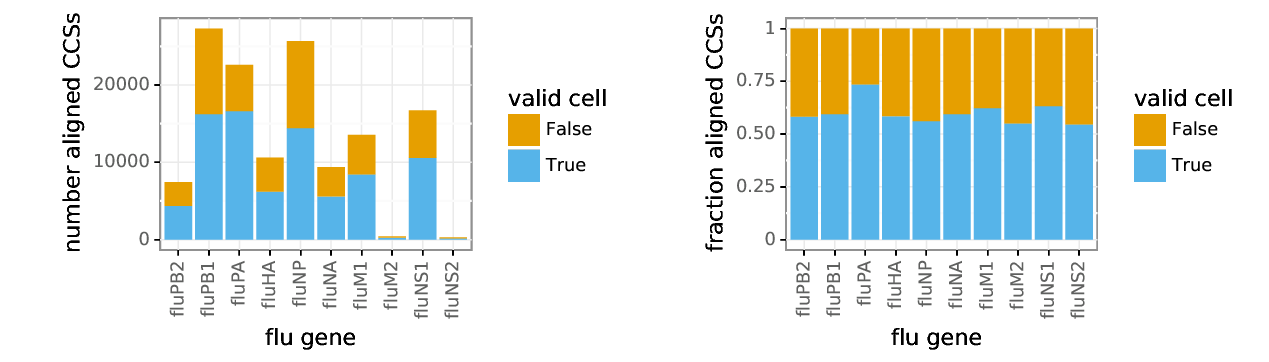

In [41]:
valid_cells_plots = []
for pos, label in [('stack', 'number'), ('fill', 'fraction')]:
    valid_cells_plot = os.path.join(analysisdir, 'valid_cells_{0}.pdf'.format(label))
    (ggplot(df_ccs, aes('gene_aligned_target')) +
        geom_bar(aes(fill='valid_cell'), position=pos) +
        scale_fill_manual(COLOR_BLIND_PALETTE_GRAY[1 : ], name='valid cell') +
        xlab("flu gene") +
        ylab(label + ' aligned CCSs') +
        theme(axis_text_x=element_text(angle=90, hjust=0.5))
        ).save(valid_cells_plot, width=3, height=2.25)
    valid_cells_plots.append(valid_cells_plot)
showPDF(valid_cells_plots)

As can be seen above, a bit over half of the aligned CCSs correspond to valid cells, and there do not appear to be large differences among the flu genes.
The fact that almost half aren't in valid cells isn't too surprising, as there are many empty GEMs that have some RNA but aren't called as cells.

From here on out, we work just with the aligned CCSs in valid cells, so retain only those:

In [42]:
df_ccs = df_ccs.query('valid_cell')

### Per-gene barcodes / UMI sampling
We now want to examine how many times the typical cell barcode and UMI is observed, and also see if we expect to gain additional cell barcodes / UMIs if we sequence more.

The UMIs are shorter than the cell barcodes, and in reality the cell barcodes can be thought of as an addition to the UMI since individual molecules must come from the same cell **and** have the same UMI.
So we create a new variable called *UMI_long* that is the concatenation of the UMI and the cell barcode, and use this in place of just the UMI for identifying molecules:

In [43]:
df_ccs['UMI_long'] = df_ccs.UMI + df_ccs.barcode

Now for both these longer UMIs and the cell barcodes, we plot how many times each is observed and rarefaction plots of the saturation for each:

Number of times each cell barcode observed:


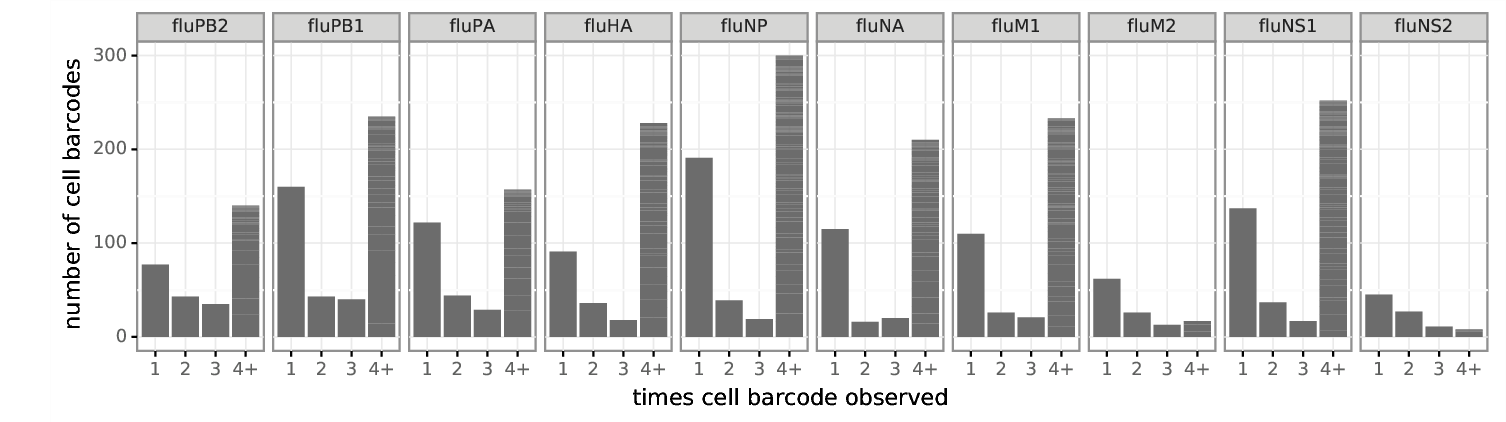

Rarefaction plot for cell barcodes:


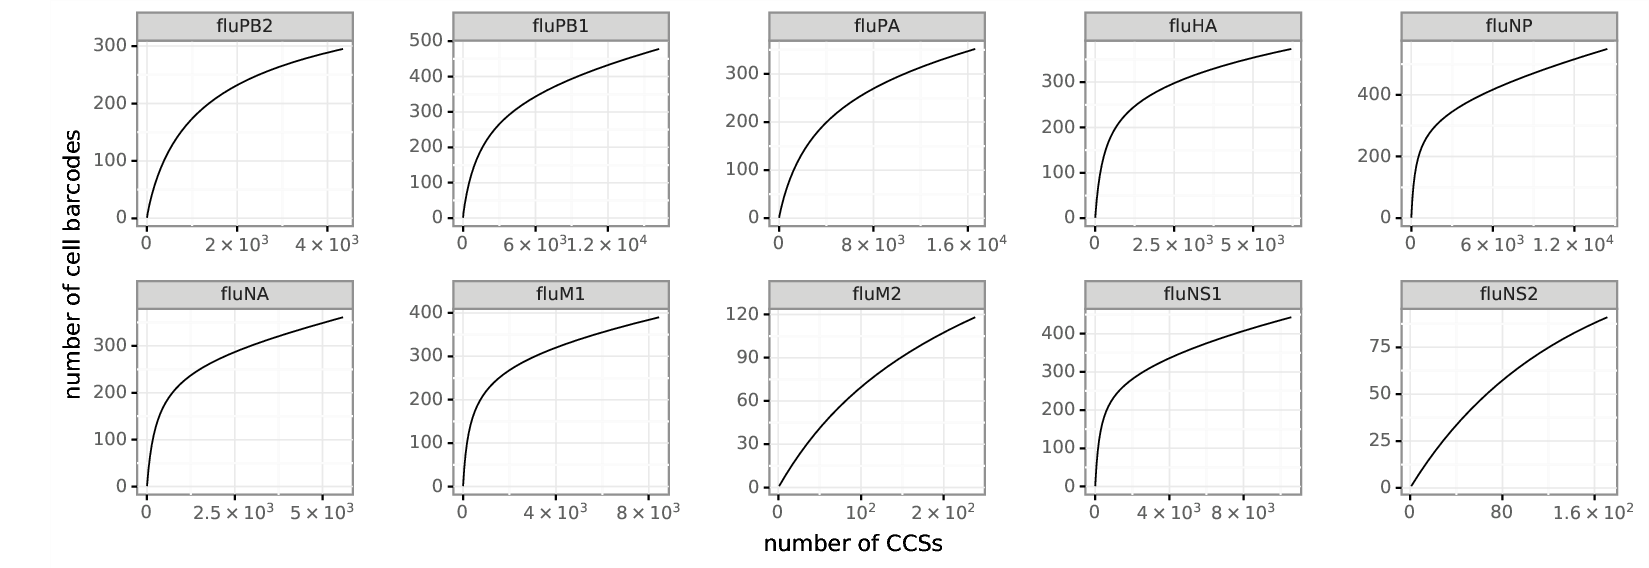

Number of times each UMI observed:


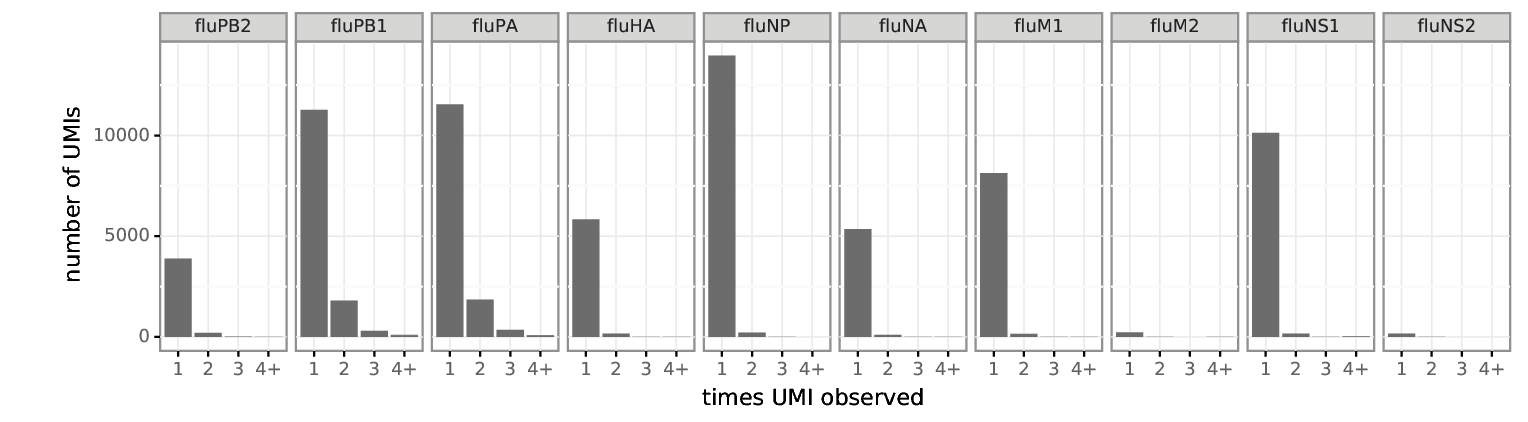

Rarefaction plot for UMIs:


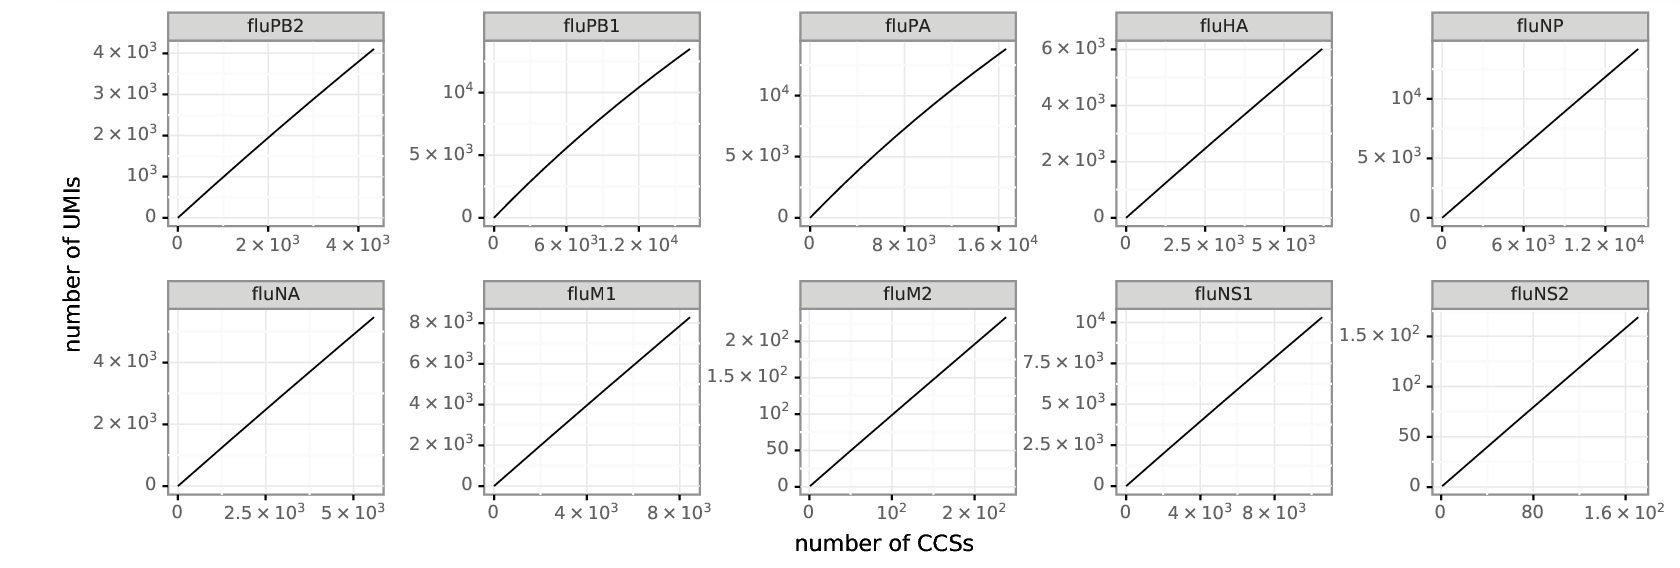

In [44]:
max_obs = 4 # plot up to this many observations

for prop, proplabel in [('barcode', 'cell barcode'), ('UMI_long', 'UMI')]:
    
    print("Number of times each {0} observed:".format(proplabel))
    df = (df_ccs
         .groupby(['gene_aligned_target', prop], as_index=False)
         .agg({'CCS':'count'})
         .rename(columns={'CCS':'times_observed', prop:'number'})
         .groupby(['gene_aligned_target', 'times_observed'], as_index=False)
         .agg('count')
         .assign(times_observed=lambda x:
                 x.times_observed
                 .clip(0, max_obs)
                 .map(lambda n: str(n) if n < max_obs else '{0}+'.format(max_obs)))
        )
    nobservedplot = os.path.join(analysisdir, '{0}_nobserved.pdf'.format(proplabel))
    (ggplot(df, aes('times_observed', 'number')) +
        geom_bar(stat='identity') +
        facet_wrap('gene_aligned_target', nrow=1) +
        xlab('times {0} observed'.format(proplabel)) +
        ylab('number of {0}s'.format(proplabel))
        ).save(nobservedplot, width=13, height=3)
    showPDF(nobservedplot)
    
    print("Rarefaction plot for {0}s:".format(proplabel))
    rarefyplot = os.path.join(analysisdir, '{0}_rarefaction.pdf'.format(proplabel))
    dms_tools2.plot.plotRarefactionCurves(df_ccs, prop,
            rarefyplot, facet_col='gene_aligned_target',
            ylabel='number of {0}s'.format(proplabel), xlabel='number of CCSs',
            nrow=2)
    showPDF(rarefyplot)

These plots make clear that we are nowhere near saturation of the UMIs, very few are observed more than once and the rarefaction plots indicate no saturation.

But for the cell barcodes, it appears that a majority of the barcodes that we observe are observed multiple times for all genes except the lowly expressed isoforms M2 and NS2.
However, we are still not all that close to saturation of cell barcodes in the rarefaction plots--things are flattening off, but we could still clearly get more barcodes for all genes if we sequenced more.

### Genes sequenced per cell
We will now examine how completely the different genes are sequenced in each cell.

Specifically, we want to determine how many genes are captured by cell, and which genes tend to be present or missing.
Note that this analysis is limited to only cells in which at least one gene is captured.

The M2 and NS2 isoforms are at very low abundance, and their sequences are actually included within the longer unspliced major M1 and NS2 isoforms.
We therefore perform the analysis both on all isoforms and just the major isoforms:

In [45]:
# analyze all flu genes, and just major isoforms
all_isoforms = set(mapper.targetseqs.keys())
major_isoforms = {sorted(isoforms)[0] for isoforms in mapper.target_isoforms.values()}
print("Analyzing all {0} flu genes and just the {1} major isoforms ({2})."
      .format(len(all_isoforms), len(major_isoforms), ', '.join(major_isoforms)))

Analyzing all 10 flu genes and just the 8 major isoforms (fluPB1, fluNA, fluNS1, fluM1, fluPB2, fluPA, fluHA, fluNP).



Analysis of all isoforms (10 genes):


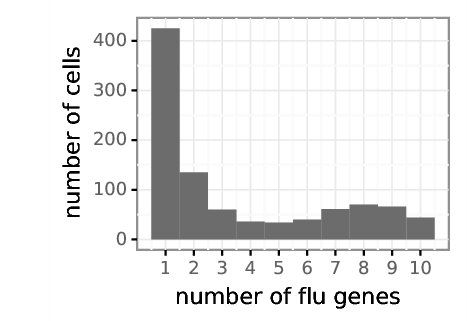

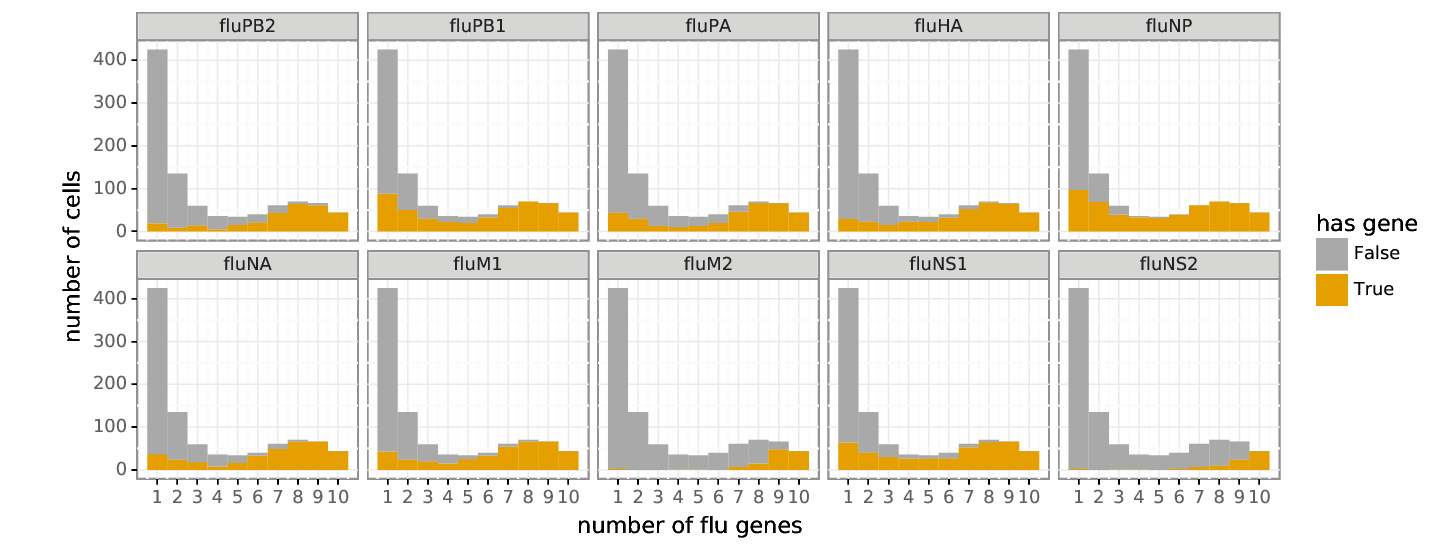


Analysis of major isoforms (8 genes):


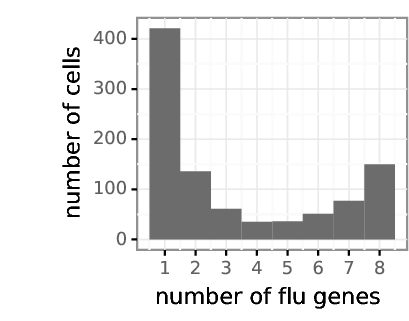

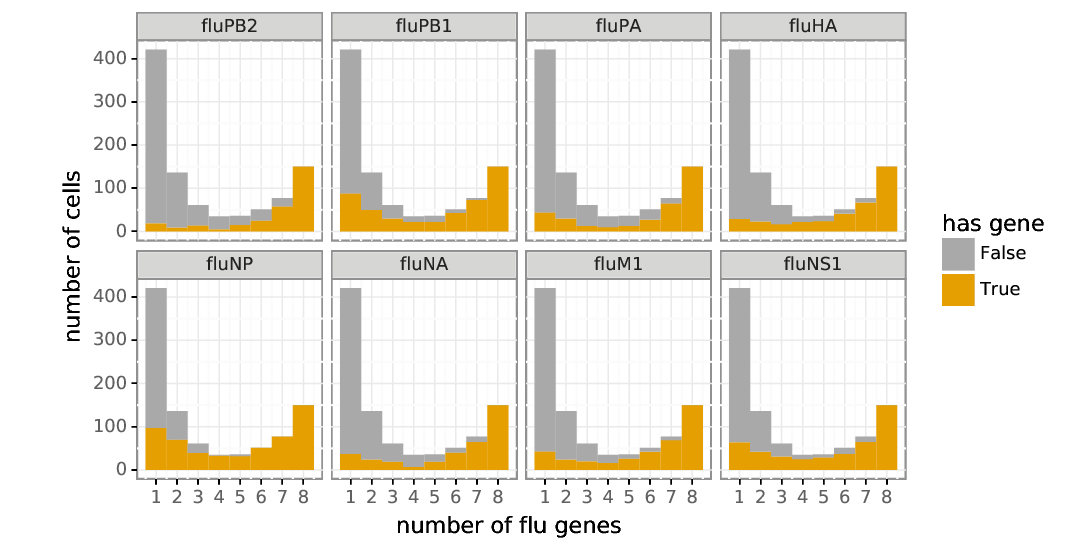

In [46]:
for isoforms, isoform_desc in [
        (all_isoforms, 'all'), (major_isoforms, 'major')]:

    print("\nAnalysis of {0} isoforms ({1} genes):"
          .format(isoform_desc, len(isoforms)))
    
    # calculate genes per cell
    genes_per_cell = (
        df_ccs
        .query('gene_aligned_target in @isoforms')
        .groupby(['barcode'])
        .agg({'gene_aligned_target':lambda x: len(x.unique())})
        .rename(columns={'gene_aligned_target':'number of flu genes'})
        )
    # calculate genes per cell conditioned on presence of each gene
    genes_per_cell_by_gene = (
        df_ccs
        .query('gene_aligned_target in @isoforms')
        .assign(has_gene=True,
                gene_aligned_target=lambda x: 
                    x.gene_aligned_target.cat.remove_unused_categories())
        [['barcode', 'gene_aligned_target', 'has_gene']]
        .groupby(['barcode', 'gene_aligned_target'])
        .agg('any').fillna(False)
        .join(genes_per_cell)
        .reset_index()
        )

    # plot distribution of genes per cell
    plotwidth = 1 + 0.2 * len(isoforms)
    genes_per_cell_plot = os.path.join(analysisdir,
            '{0}_genes_per_cell.pdf'.format(isoform_desc))
    (ggplot(genes_per_cell, aes('number of flu genes')) +
        geom_histogram(binwidth=1) +
        scale_x_continuous(breaks=range(1, len(isoforms) + 1)) +
        ylab('number of cells')
        ).save(genes_per_cell_plot, height=2.25, width=plotwidth)
    showPDF(genes_per_cell_plot, 80 * plotwidth)
    
    # plot distribution of genes per cell faceted by gene presence
    genes_per_cell_by_gene_plot = os.path.join(analysisdir,
            '{0}_genes_per_cell_by_gene.pdf'.format(isoform_desc))
    plotwidth=1 + len(isoforms)**2 * 0.1
    (ggplot(genes_per_cell_by_gene,
            aes('number of flu genes', fill='has_gene')) +
        geom_histogram(binwidth=1) +
        scale_x_continuous(breaks=range(1, len(isoforms) + 1)) +
        ylab('number of cells') +
        facet_wrap('~gene_aligned_target', nrow=2) +
        scale_fill_manual(COLOR_BLIND_PALETTE_GRAY, name='has gene')
        ).save(genes_per_cell_by_gene_plot, height=4.25, width=plotwidth)
    showPDF(genes_per_cell_by_gene_plot, 80 * plotwidth)

## Call mutations
We have already technically called mutations far above when we passed a `dms_tools2.minimap2.MutationCaller` to the `dms_tools2.pacbio.matchAndAlignSeqs` method used to create the data frame holding the results.
We now want to examine these mutations and impose criteria (such as being observed in multiple sequences) to determine which ones are real.

### Number of mutations per gene
First, we simply calculate and plot the number of mutations called per aligned sequence for each gene and mutation type, also stratifying by the viral barcode:

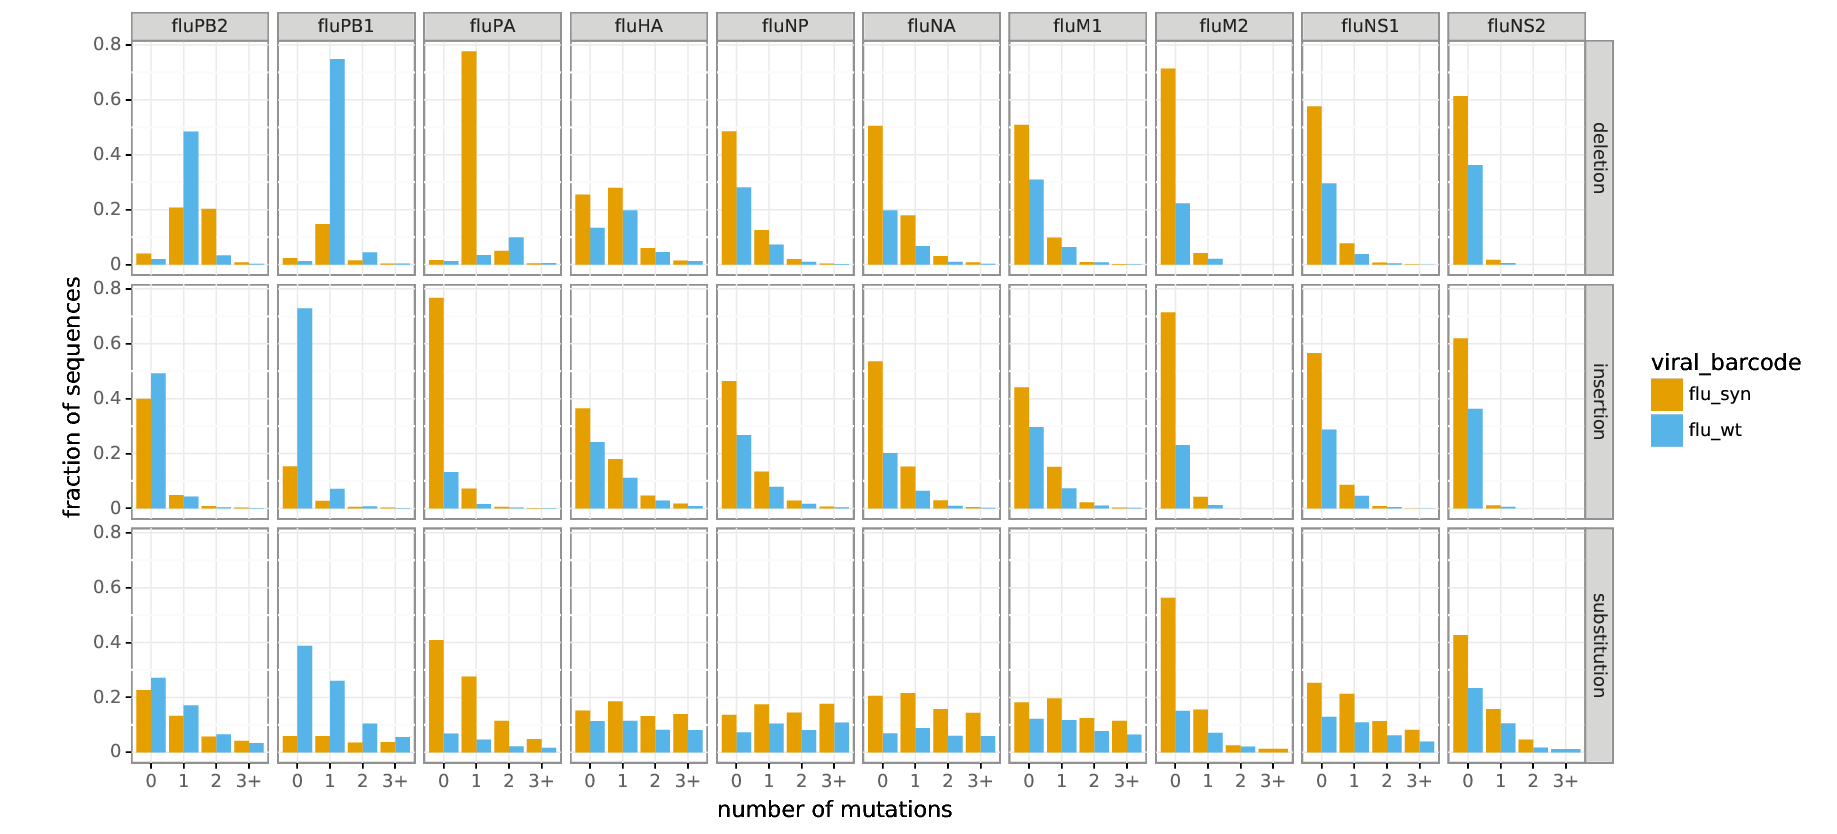

In [47]:
max_muts = 3 # plot up to this many mutations

nmuts_df = (
    df_ccs
    .assign(substitution=lambda x: x.gene_aligned_mutations.apply(
                    dms_tools2.minimap2.Mutations.substitutions),
            insertion=lambda x: x.gene_aligned_mutations.apply(
                    dms_tools2.minimap2.Mutations.insertions),
            deletion=lambda x: x.gene_aligned_mutations.apply(
                    dms_tools2.minimap2.Mutations.deletions))
    .melt(id_vars=['gene_aligned_target', 'viral_barcode'],
          value_vars=['substitution', 'insertion', 'deletion'],
          var_name='mutation_type', value_name='mutation_list')
    # workaround melt / categorical bug: https://github.com/pandas-dev/pandas/issues/15853
    .assign(gene_aligned_target=lambda x: pandas.Categorical(
            x.gene_aligned_target, targetnames))
    .assign(number=lambda x: x.mutation_list.map(len).clip(0, max_muts)
            .map(lambda n: str(n) if n < max_muts else '{0}+'.format(max_muts)))
    .assign(nseqs=1) # dummy variable for counting
    .groupby(['gene_aligned_target', 'viral_barcode', 'mutation_type', 'number'])
    .agg({'nseqs':'count'})
    .assign(fraction=lambda x: # see https://stackoverflow.com/a/23377155
                x.div(df_ccs.assign(nseqs=1)
                              .groupby('gene_aligned_target')
                              .agg({'nseqs':'count'}),
                      'gene_aligned_target'))
    .reset_index()
    )

nmuts_plot = os.path.join(analysisdir, 'nmuts_plot.pdf')
(ggplot(nmuts_df, aes('number', 'fraction', fill='viral_barcode')) +
    geom_bar(stat='identity', position=position_dodge()) +
    facet_grid('mutation_type ~ gene_aligned_target') +
    xlab('number of mutations') +
    ylab('fraction of sequences') +
    scale_fill_manual(COLOR_BLIND_PALETTE_GRAY[1 : ])
    ).save(nmuts_plot, width=14, height=7)
showPDF(nmuts_plot)

We see above that we almost always call at least one deletion for PB2, PB1, and PA.
This is expected since these genes often have internal deletions. We also call a lot of deletions for HA, which is less expected. For the other genes, deletions are rarely called.

We don't see many insertions (as perhaps expected).

We see quite a few point substitutions, with the number probably about proportional to gene length (recalling that the polymerase genes are actually usually internally deleted in our data, and so not all that long). 
At our sequencing accuracy of 99.9% cutoff, we would expect about 1.5 point substitutions per gene for genes like HA, NP, and NA. 
In reality it is a bit higher, but of course some of this is probably due to their also being **real** point substitutions.
In any case, the high substitution rate indicates that the sequences probably have an appreciable degree of errors from sequencing or PCR that we will need to correct somehow...

The behavior of the two different viral barcodes generally looks comparable in terms of the distribution of mutations for all genes except the polymerase ones (where we already have observed that selective enrichment of certain deletions leads to some biases) and M2 / NS2 (where the counts are very low).

### Lengths of indels
Now we look at the length distribution of the insertion and deletion mutations, again stratifying by gene and viral barcode.
*A priori*, we might expect two kinds of mutations: very short indels (possibly due to sequencing errors), and longer internal deletions that are real.

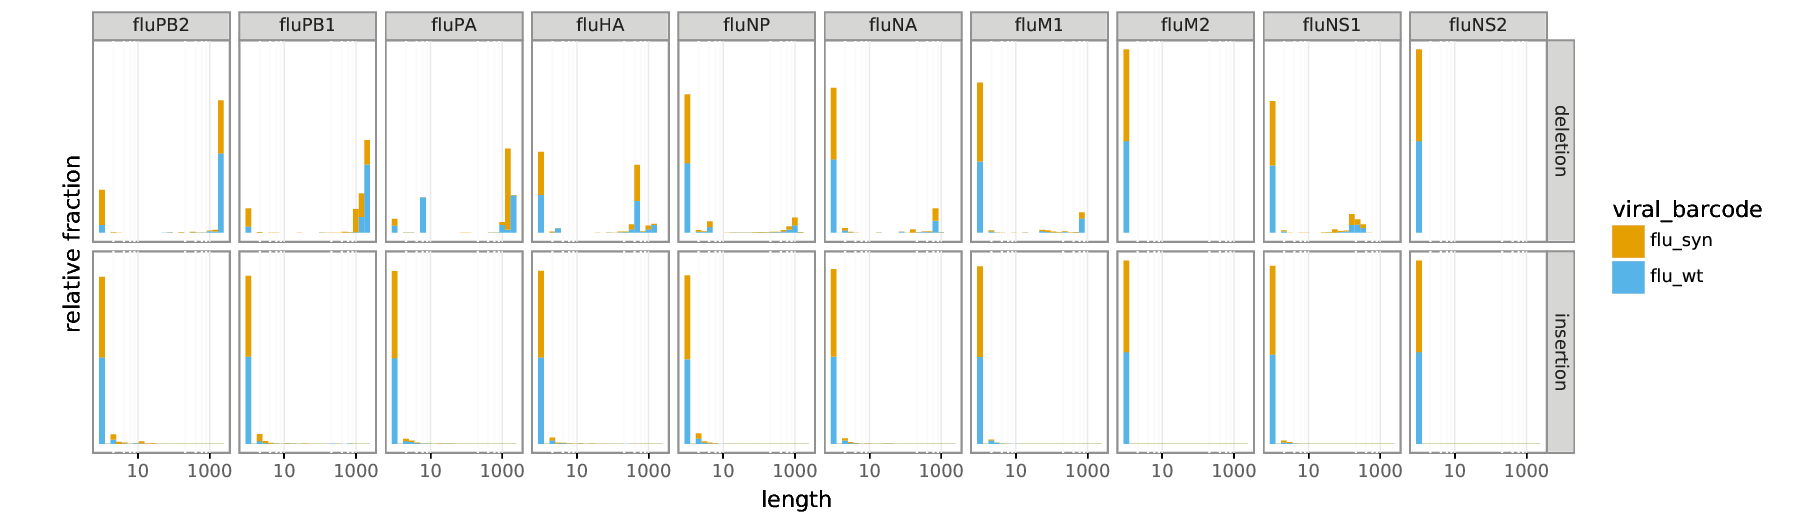

In [48]:
indel_len_df = (
    df_ccs
    .assign(insertion=lambda x: x.gene_aligned_mutations.apply(
                    dms_tools2.minimap2.Mutations.insertions, returnval='length'),
            deletion=lambda x: x.gene_aligned_mutations.apply(
                    dms_tools2.minimap2.Mutations.deletions, returnval='length'))
    .melt(id_vars=['gene_aligned_target', 'viral_barcode'],
          value_vars=['insertion', 'deletion'],
          var_name='mutation_type', value_name='mutation_length')
    .groupby(['gene_aligned_target', 'viral_barcode', 'mutation_type'])
    .mutation_length
    .sum()
    # column of lists to long form: https://stackoverflow.com/a/27266225
    .apply(pandas.Series)
    .stack()
    .rename('length')
    .reset_index()
    # workaround melt / categorical bug: https://github.com/pandas-dev/pandas/issues/15853
    .assign(gene_aligned_target=lambda x: pandas.Categorical(
            x.gene_aligned_target, targetnames))
    ) 
    
indel_len_plot = os.path.join(analysisdir, 'indel_len_plot.pdf')
(ggplot(indel_len_df, aes('length', fill='viral_barcode')) +
    geom_histogram(aes(y='..density..')) +
    facet_grid('mutation_type ~ gene_aligned_target') +
    ylab('relative fraction') +
    scale_y_continuous(breaks=None) +
    scale_x_log10(labels=lambda x: x.astype('int') 
                  if all(x.astype('int') == x) else x) +
    scale_fill_manual(COLOR_BLIND_PALETTE_GRAY[1 : ])
    ).save(indel_len_plot, width=14, height=4)
showPDF(indel_len_plot)

These plots are consistent with virtually all of the insertions being very short, plausibly due to sequencing errors.
For most genes, most the deletions are also very short and plausibly due to sequencing errors.
However, for some genes (especially the polymerase genes but also to some extent HA and a few others), many of the deletions are very long and unlikely to be sequencing errors.

### Accuracy of mutations
Below we compute the distributions of accuracies for mutations from the Q-values, and then plot the error rate (1 minus the accuracy) for these mutations.
We also do this for **all** sites in the genes.

First, plot the accuracy of all sites in the aligned genes:

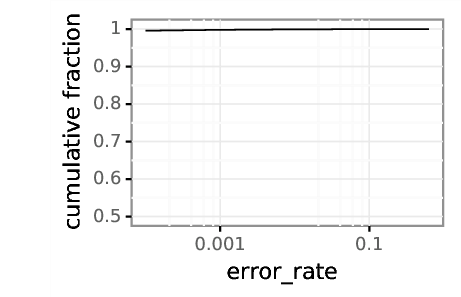

In [49]:
min_error_rate = 1e-4 # plot error rates down to this low

# data frame with accuracies of all sites
all_acc_df = (
    pandas.DataFrame({
        'accuracy':dms_tools2.pacbio.qvalsToAccuracy(df_ccs
                    .gene_qvals.apply(pandas.Series).stack().values,
                    no_avg=True)})
    .assign(error_rate=lambda x: 1 - x.accuracy.clip(upper=1 - min_error_rate))
    )

# cumulative fraction plot
all_acc_plot = os.path.join(analysisdir, 'all_acc_plot.pdf')
(ggplot(all_acc_df, aes('error_rate')) +
    stat_ecdf() +
    ylab('cumulative fraction') +
    scale_x_log10() +
    scale_y_continuous(limits=(0.5, 1)) 
    ).save(all_acc_plot, width=3, height=2)
showPDF(all_acc_plot, width=300)

As can be seen from the above plot, the vast majority of sites have accuracies > 99.99%.

Now we make the same plot for just the accuracy of the mutated sites:

In [50]:
mut_acc_df = (
    df_ccs
    .assign(insertion=lambda x: x.gene_aligned_mutations.apply(
                    dms_tools2.minimap2.Mutations.insertions, returnval='accuracy'),
            deletion=lambda x: x.gene_aligned_mutations.apply(
                    dms_tools2.minimap2.Mutations.deletions, returnval='accuracy'),
            substitution=lambda x: x.gene_aligned_mutations.apply(
                    dms_tools2.minimap2.Mutations.substitutions, returnval='accuracy'))
    .melt(id_vars=['gene_aligned_target', 'viral_barcode'],
          value_vars=['insertion', 'deletion', 'substitution'],
          var_name='mutation_type', value_name='accuracy')
    .groupby(['gene_aligned_target', 'viral_barcode', 'mutation_type'])
    .accuracy
    .sum()
    # column of lists to long form: https://stackoverflow.com/a/27266225
    .apply(pandas.Series)
    .stack()
    .rename('accuracy')
    .reset_index()
    # workaround melt / categorical bug: https://github.com/pandas-dev/pandas/issues/15853
    .assign(gene_aligned_target=lambda x: pandas.Categorical(
            x.gene_aligned_target, targetnames))
    .assign(error_rate=lambda x: 1 - x.accuracy.clip(upper=1 - min_error_rate))
    )

mut_acc_plot = os.path.join(analysisdir, 'mut_acc_plot.pdf')
(ggplot(mut_acc_df, aes('error_rate', color='viral_barcode')) +
    stat_ecdf() +
    facet_grid('mutation_type ~ gene_aligned_target') +
    ylab('cumulative fraction') +
    scale_x_log10() +
    scale_y_continuous(limits=(0.5, 1)) +
    scale_color_manual(COLOR_BLIND_PALETTE_GRAY[1 : ])
    ).save(mut_acc_plot, width=14, height=4)
showPDF(mut_acc_plot)

TypeError: object of type 'NoneType' has no len()

As can be seen above, for many types of mutations the accuracies of the mutations are clearly lower.
This is the case for the insertions, the deletions in most genes other than the polymerase genes (which probably have long real deletions), and to a lesser degree for the substitution mutations.

This provides evidence that at least a reasonable fraction of sites that we call as having mutations really are lower accuracy mis-calls, and also suggests that taking the accuracies (Q-values) into account may be useful.

## Analyze flu sequences at cell level
Now we want to analyze the results at the level of cells.
In particular, we want to try to build up accurate calls of the full sequences of the flu genes in individual infected cells.
Because it appears that individual CCSs may not be sufficiently accurate to call these, we in particular look for cells where we have multiple CCSs to take the consensus of these for the cell.

Of course, this approach of building consensus of CCSs from the same cell depends on the assumption that the cell was only infected by a single virion (only sometimes true based on the analyses with `Monocle`...) and that _de novo_ mutations did not arise rapidly in the first few rounds of genome replication after infection (probably usually true given what is known about the virus's mutation rate).

### Aggregate data at the cell level
First, we aggregate the information for each cell barcode, flu gene, and viral barcode into a new data frame called *df_cells*.
We aggregate by cell barcode and flu gene because we would like to build the consensus for each flu gene for each cell, and we aggregate by viral barcode because if genes come from different viral barcodes then we know that the cell must have been infected by multiple virions, one of each viral barcode (note that there could also be some cells infected by multiple virions of the same barcode that we won't catch).

For each cell barcode, flu gene, and viral barcode we calculate the number of valid aligned sequences and a list of the mutations called in each of these CCSs.
We also calculate the number of valid aligned sequences that are also **full length**, using the criterion for full length sequences defined earlier in this notebook (this is important since for some genes such as the polymerase ones, our sequencing may be highly biased against full-length sequences).

Also, because we know that we have very low levels of the minor isoforms M2 and NS2, and because sequences of the major isoforms M1 and NS1 contain the full sequences of M2 and NS2 as well, we also make a column called *major_isoform* which is true only if a flu gene is a major isoform.
We will then perform many of our operations only on these major isoforms.

In [ ]:
df_cells = (
    df_ccs
    .groupby(['barcode', 'gene_aligned_target', 'viral_barcode'])
    .apply(lambda x: pandas.Series({ # following https://stackoverflow.com/a/47103408
        'n_sequences':x.gene.count(),
        'n_sequences_full_length':x.full_length.sum(),
        'mutation_list':list(x.gene_aligned_mutations)
        }))
    .query('n_sequences > 0')
    .reset_index()
    .assign(major_isoform=lambda x: x.gene_aligned_target.isin(major_isoforms))
    )

### Genes sequenced per cell
Now for each cell and viral barcode, we tally how many genes are observed at least *N* times for several values of the threshold *N*.
We do this counting **only** for the major isoforms, so the most genes that can be observed are eight.
The reason that we tally the number of genes observed for several thresholds is to figure out how many cells we'll retain if we impose various different criterion for how many sequences we take the consensus of to call mutations.

We do this both for all sequences and for full-length sequences only.

In [ ]:
# tally how many genes observed >= this many times for each cell
n_obs = [1, 2, 3]
n_obs_labels = ['at least {0} sequence{1}'.format(
        n, 's' if n > 1 else '') for n in n_obs]
n_obs_cols = {
    'all_lengths':['n_genes_ge_{0}'.format(n) for n in n_obs],
    'full_length':['n_genes_ge_{0}_full_length'.format(n) for n in n_obs]
    }

for nseq_col, cols in [
        ('n_sequences', n_obs_cols['all_lengths']),
        ('n_sequences_full_length', n_obs_cols['full_length'])]:
    for nobs, col in zip(n_obs, cols):
        df_cells[col] = (
            df_cells
            .assign(count_gene=lambda x: # major isoform observed enough? 
                    x.major_isoform & (x[nseq_col] >= nobs))
            .groupby(['barcode', 'viral_barcode'])
            .count_gene
            .transform('sum')
            .astype('int')
            )

Now plot the number of cells with a given number of genes sequenced for several thresholds for how many sequences we require per gene.
We make these plots both for any sequence, and requiring full-length sequences.

In [ ]:
# dataframe with number of gene and full-length genes per cell
gene_counts_df = (
    df_cells
    .melt(id_vars=['barcode', 'viral_barcode'],
          value_vars=n_obs_cols['all_lengths'] + n_obs_cols['full_length'],
          var_name='minimum_observations',
          value_name='number of flu genes')
    .assign(full_length_only=lambda x: numpy.where(
          x.minimum_observations.isin(n_obs_cols['full_length']),
          'full length only', 'all lengths'))
    .assign(minimum_observations=lambda x: x.minimum_observations
          .replace(dict(zip(n_obs_cols['all_lengths'], n_obs_labels)))
          .replace(dict(zip(n_obs_cols['full_length'], n_obs_labels))))
    )

gene_counts_plot = os.path.join(analysisdir, 'gene_counts.pdf')
(ggplot(gene_counts_df, aes('number of flu genes', fill='viral_barcode')) +
    geom_bar(position=position_dodge()) +
    facet_grid('full_length_only ~ minimum_observations') +
    scale_x_continuous(limits=(0.5, len(major_isoforms) + 0.5),
        breaks=list(range(1, len(major_isoforms) + 1))) +
    ylab("number of cells") +
    scale_fill_manual(COLOR_BLIND_PALETTE_GRAY[1 : ])
    ).save(gene_counts_plot, height=4.25, width=2 * (1 + len(n_obs)))
showPDF(gene_counts_plot)

We see that for a reasonable number of cells, we have all 8 genes sequenced multiple times.
This might be even better than it initially seems, if we recall (as detailed more in the `Monocle` analysis) that some cells simply fail to express all viral genes.
This bodes well for calling viral genome sequences from these cells using the consensus of multiple CCSs.

Unfortunately, we see that things are much worse when we limit ourselves to full-length sequences only.
Part of the reason may be that some cells are simply infected by viruses with internal deletions.
But based on the data above showing the polymerase gene sequences are very highly biased towards internal deletions, probably the larger factor is that the sequencing is doing a very poor job of capturing full-length polymerase sequences.

## Call mutations for viruses in cells

In [ ]:
# object to call mutation consensus
mutcons = dms_tools2.minimap2.MutationConsensus()

for mutation_type in ['substitutions', 'deletions', 'insertions']:
    df_cells[mutation_type] = df_cells.mutation_list.apply(
            mutcons.callConsensus, mutation_type=mutation_type)



In [ ]:
df_cells.head()